In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('RFLFSODataFull.csv')  
X = data.drop(columns=['FSO_Att', 'RFL_Att', 'Time'])  
y_fso = data['FSO_Att']
y_rfl = data['RFL_Att']

In [3]:
# Using backward_selection 
def backward_selection(X, y, model):
    remaining_features = list(X.columns)
    best_features = remaining_features.copy()
    scores = []
    rmse_scores = []
    r2_scores = []
    removed_features = []

    while len(remaining_features) > 1:
        # split the dataset
        X_train, X_test, y_train, y_test = train_test_split(X[remaining_features], y, test_size=0.2, random_state=42)
        
        # train the model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        #Evaluation 
        rmse = sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        scores.append((remaining_features.copy(), rmse, r2))
        rmse_scores.append(rmse)
        r2_scores.append(r2)
        
        #Find the least important faetures
        importances = model.feature_importances_
        least_important_feature = remaining_features[np.argmin(importances)]
        
        #removing features
        remaining_features.remove(least_important_feature)
        removed_features.append(least_important_feature)

    return scores, rmse_scores, r2_scores, removed_features

In [4]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

#backward_selection for fso and rfl
scores_fso, rmse_fso, r2_fso, removed_features_fso = backward_selection(X, y_fso, rf_model)
scores_rfl, rmse_rfl, r2_rfl, removed_features_rfl = backward_selection(X, y_rfl, rf_model)

In [5]:
#Plot the feature selection 
def plot_feature_removal(rmse_scores, r2_scores, removed_features, title):
    fig, ax1 = plt.subplots(figsize=(18, 8))
    ax1.set_xlabel('Removed Features')
    ax1.set_ylabel('RMSE', color='tab:blue')
    ax1.plot(range(len(rmse_scores)), rmse_scores, color='tab:blue', marker='o', label='RMSE')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.legend(loc='upper left')

    ax2 = ax1.twinx()
    ax2.set_ylabel('R²', color='tab:orange')
    ax2.plot(range(len(r2_scores)), r2_scores, color='tab:orange', marker='o', linestyle='--', label='R²')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax2.legend(loc='upper right')

    ax1.set_xticks(range(len(removed_features)))
    ax1.set_xticklabels(removed_features, rotation=90, fontsize=8, ha='center', va='top')
    plt.title(title)
    plt.tight_layout()
    plt.grid(axis='x')
    plt.show()

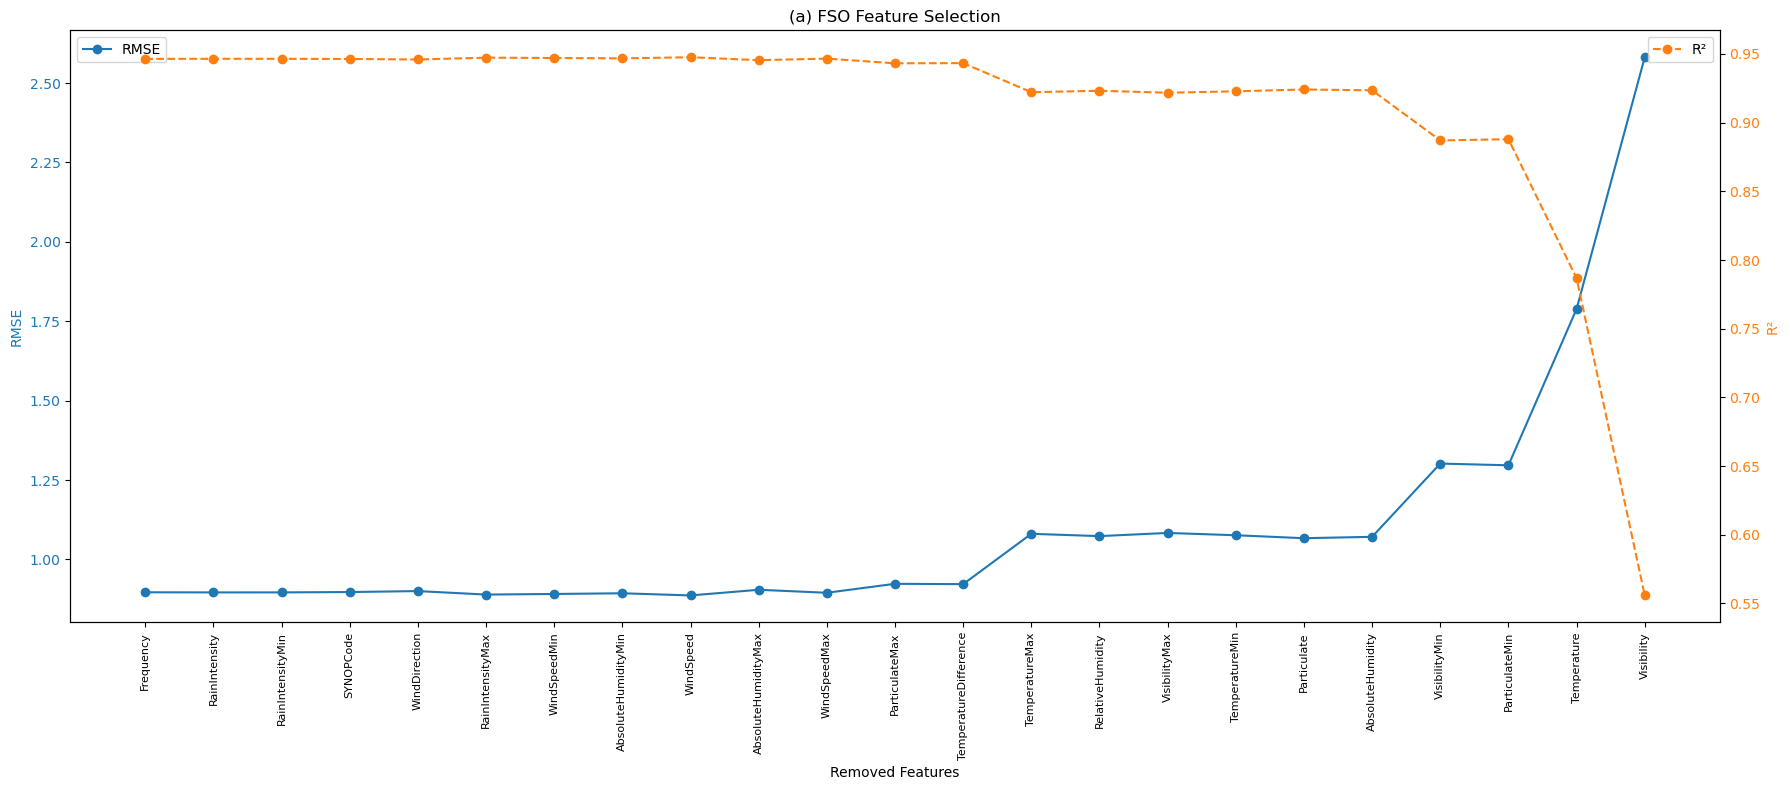

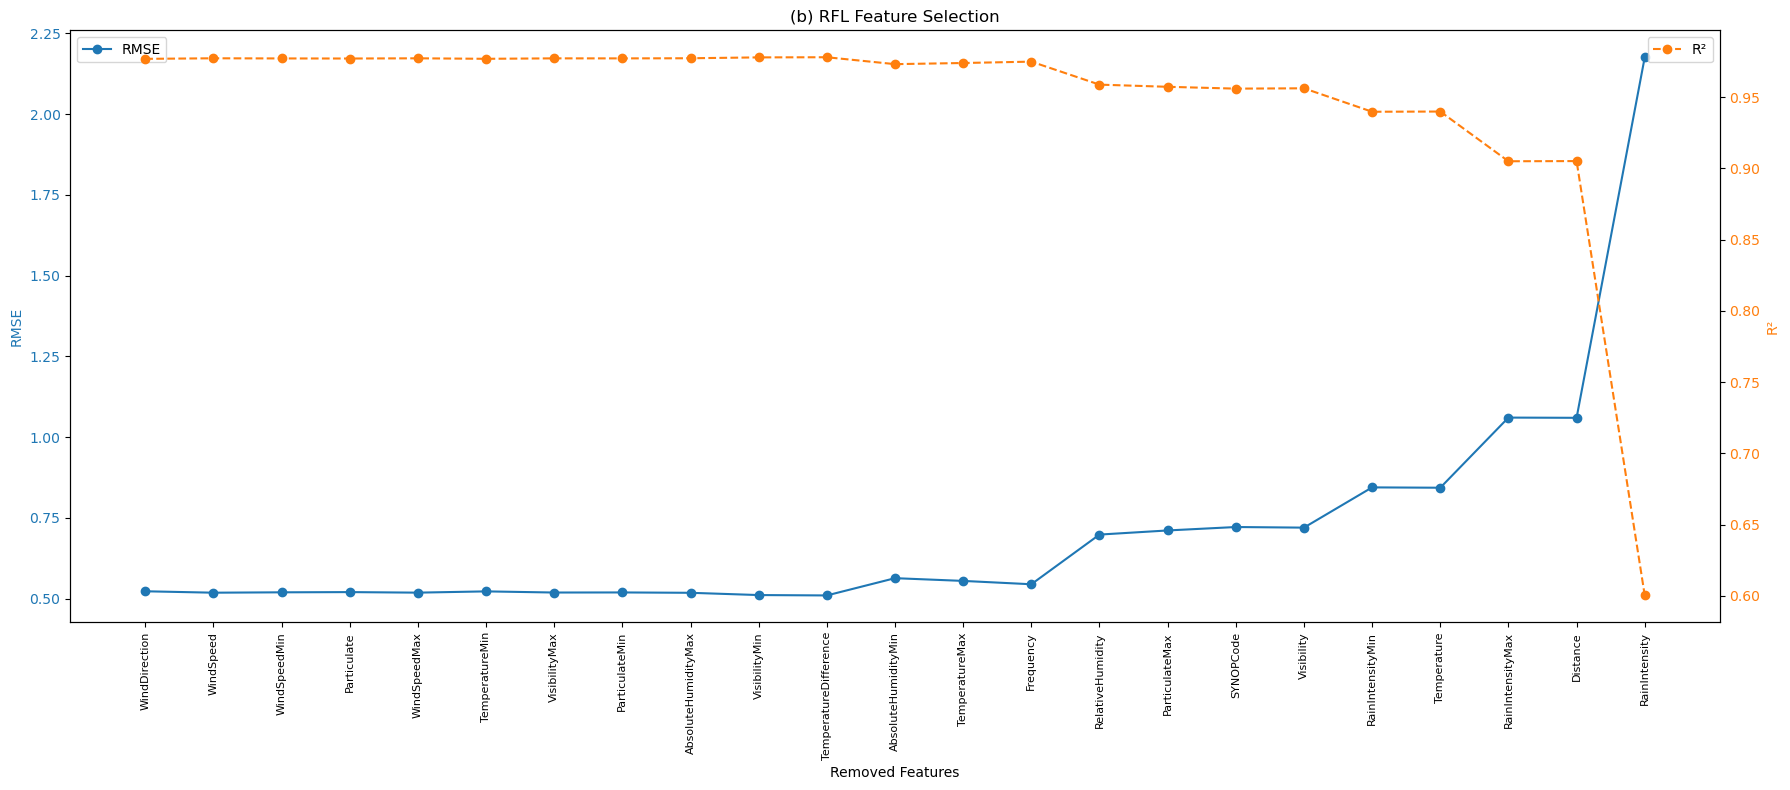

In [6]:
plot_feature_removal(rmse_fso, r2_fso, removed_features_fso, "(a) FSO Feature Selection")
plot_feature_removal(rmse_rfl, r2_rfl, removed_features_rfl, "(b) RFL Feature Selection")

In [7]:
synop_df = {code: group.reset_index(drop=True) for code, group in data.groupby('SYNOPCode')}

#clear weather df
clear_df = synop_df[0]
X_clear = clear_df.drop(columns=['FSO_Att', 'RFL_Att', 'Time']) 
y_clear_fso = clear_df['FSO_Att']
y_clear_rfl = clear_df['RFL_Att']
clear_df

,FSO_Att,RFL_Att,AbsoluteHumidity,AbsoluteHumidityMax,AbsoluteHumidityMin,Distance,Frequency,Particulate,ParticulateMax,ParticulateMin,...,TemperatureMax,TemperatureMin,Time,Visibility,VisibilityMax,VisibilityMin,WindDirection,WindSpeed,WindSpeedMax,WindSpeedMin
0,7.913289,6.927868,17.595709,17.615907,17.340148,2115.338398,83500000000,0.000000,0.000000,0.000000,...,26.603030,24.680849,9,65884.518460,72336.362233,65617.543754,88.755450,3.057066,6.863808,3.007939
1,7.451176,4.412096,17.549693,17.572415,17.299439,2113.999257,73500000000,0.000000,0.000000,0.000000,...,26.377164,24.313108,9,64963.410920,68753.386153,60379.327485,99.790057,2.727910,6.468903,2.537393
2,7.072747,6.268740,17.290230,17.644014,16.037894,2118.689047,83500000000,0.000000,0.000000,0.000000,...,27.670822,23.150277,10,54794.281070,54821.773817,50850.155963,65.730085,1.674810,2.826916,1.640809
3,6.949288,4.317853,16.820880,17.066776,15.895622,2114.632339,73500000000,0.000000,0.000000,0.000000,...,26.522100,23.174815,10,50205.641590,52519.927530,45374.510898,88.127497,0.962068,2.780643,0.886951
4,7.361052,6.114514,16.813820,17.953974,15.227225,2116.786055,83500000000,0.000000,0.000000,0.000000,...,26.305736,24.864100,10,59038.325990,64418.329138,54461.246506,84.167414,1.881007,4.476298,1.874052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56959,9.150012,11.968291,23.283256,24.142871,22.169805,3970.846129,83500000000,0.000000,0.000000,0.000000,...,27.257926,26.013205,4,13041.847800,13458.340663,12411.852994,91.391749,0.000000,0.027596,0.000000
56960,9.333777,11.538030,23.259618,25.104895,21.005496,3969.230652,73500000000,0.000000,0.000000,0.000000,...,28.101044,25.032282,4,15959.633590,16232.735439,15345.485232,47.997946,0.075640,0.349551,0.069834
56961,8.873168,11.491891,23.331697,23.996130,22.148649,3968.373512,83500000000,0.000000,0.000000,0.000000,...,28.249678,26.205773,4,13129.663750,13948.560177,11925.979953,103.963102,0.052282,0.178062,0.049824
56962,9.538886,11.526529,21.241027,21.624932,20.736391,3967.550165,73500000000,29.693160,30.761540,28.497137,...,26.880084,25.031934,5,15082.787860,15522.762221,14842.654291,82.090779,0.443520,1.838449,0.413146


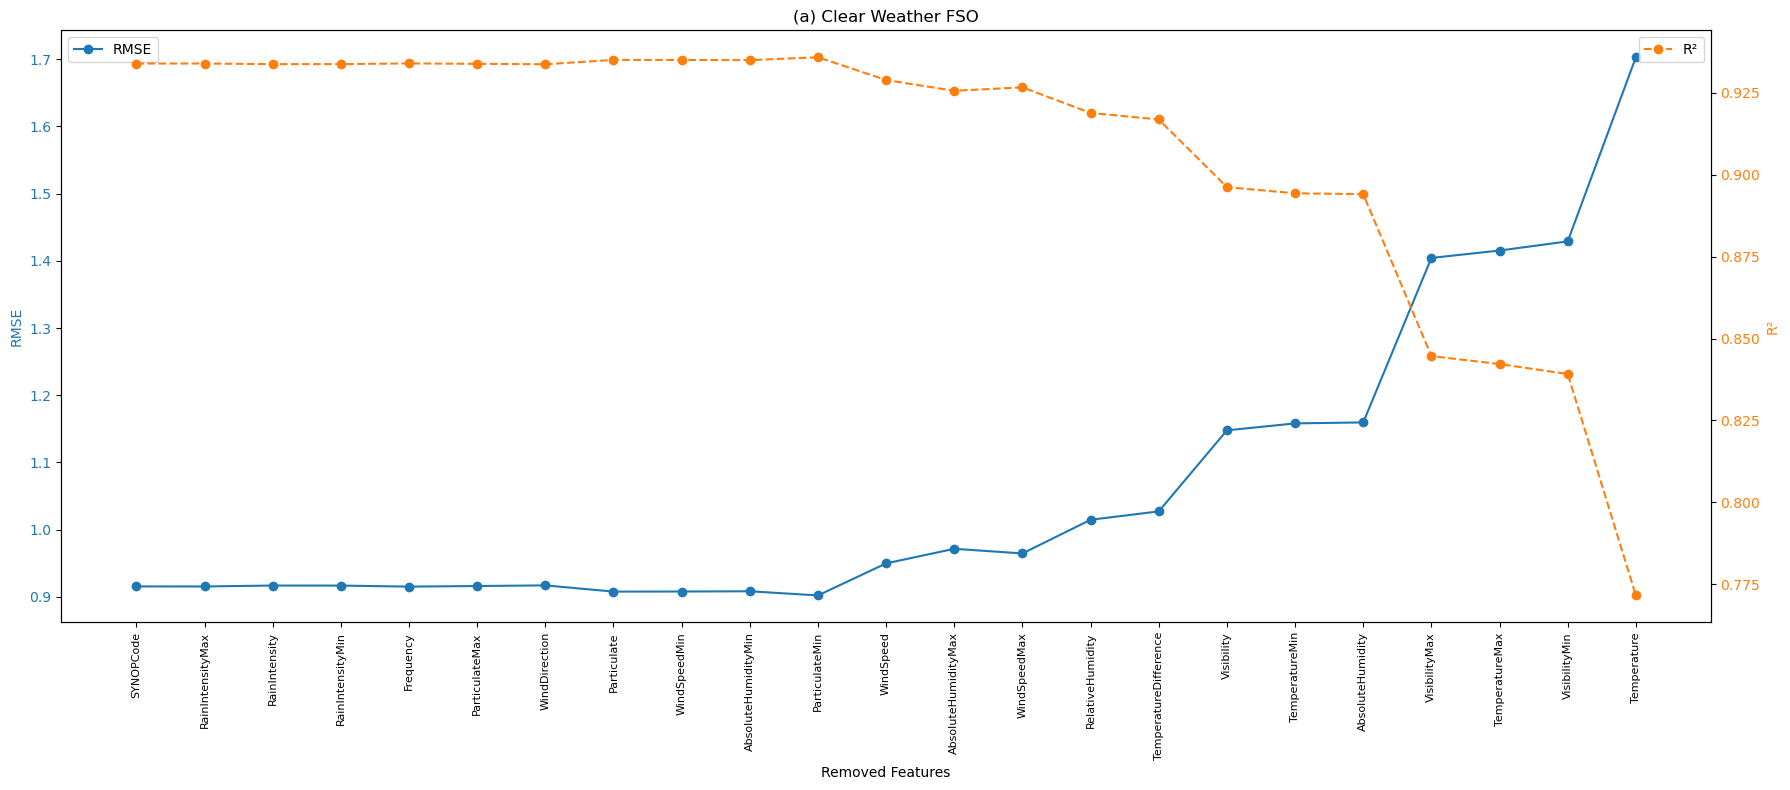

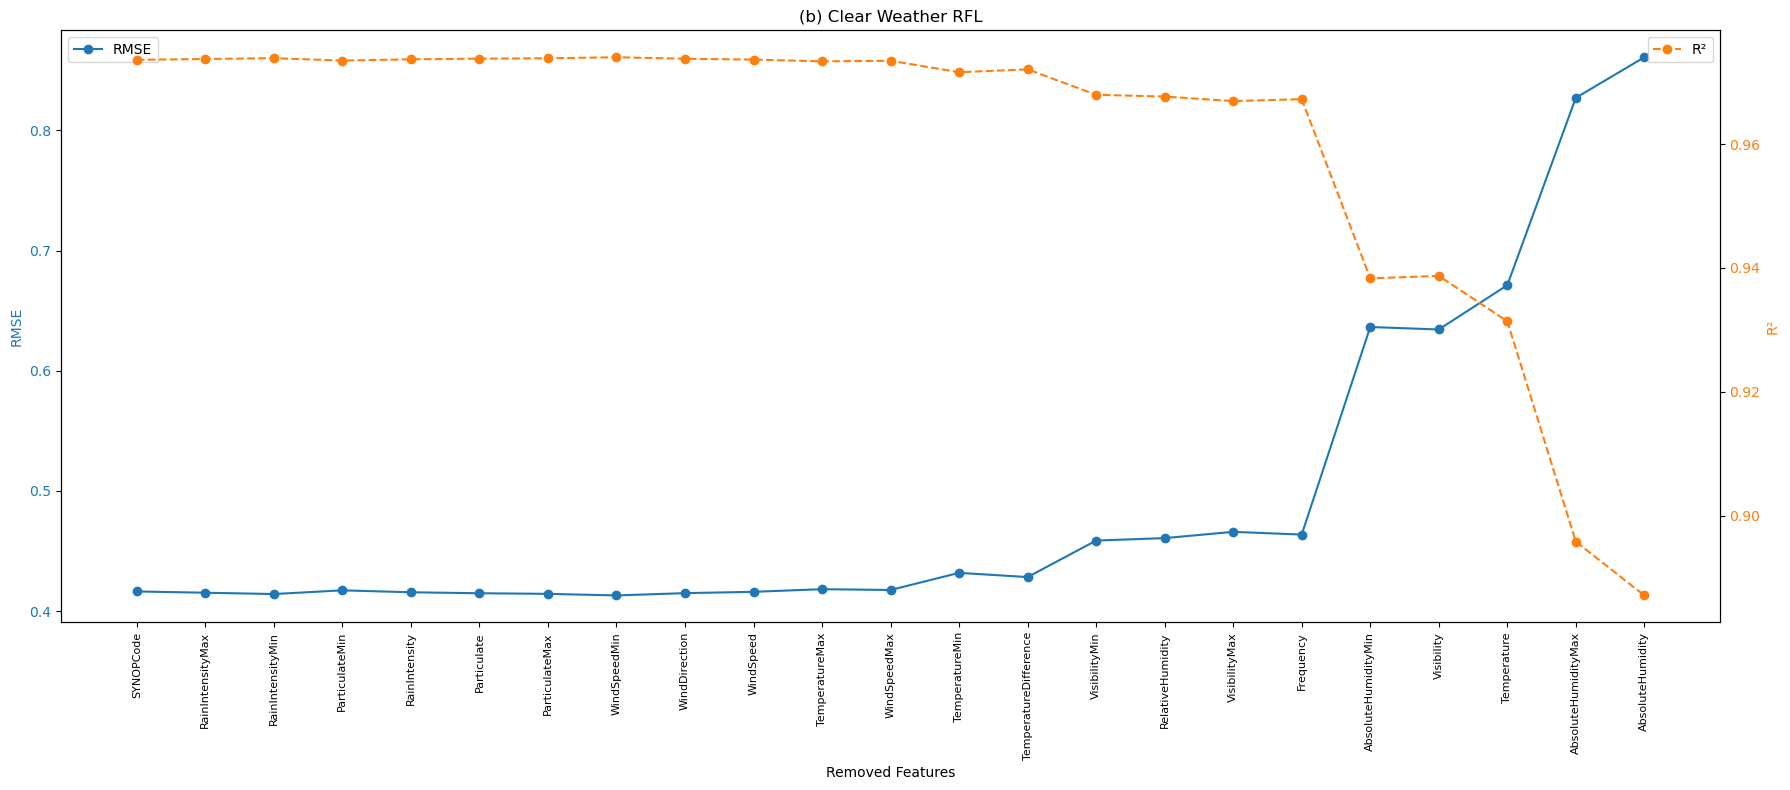

In [8]:
scores_clear_fso, rmse_clear_fso, r2_clear_fso, removed_features_clear_fso = backward_selection(X_clear, y_clear_fso, rf_model)
scores_clear_rfl, rmse_clear_rfl, r2_clear_rfl, removed_features_clear_rfl = backward_selection(X_clear, y_clear_rfl, rf_model)

plot_feature_removal(rmse_clear_fso, r2_clear_fso, removed_features_clear_fso, "(a) Clear Weather FSO")
plot_feature_removal(rmse_clear_rfl, r2_clear_rfl, removed_features_clear_rfl, "(b) Clear Weather RFL")

In [9]:
#duststorm weather df
duststorm_df = synop_df[3]
X_duststorm = duststorm_df.drop(columns=['FSO_Att', 'RFL_Att', 'Time']) 
y_duststorm_fso = duststorm_df['FSO_Att']
y_duststorm_rfl = duststorm_df['RFL_Att']
duststorm_df 

,FSO_Att,RFL_Att,AbsoluteHumidity,AbsoluteHumidityMax,AbsoluteHumidityMin,Distance,Frequency,Particulate,ParticulateMax,ParticulateMin,...,TemperatureMax,TemperatureMin,Time,Visibility,VisibilityMax,VisibilityMin,WindDirection,WindSpeed,WindSpeedMax,WindSpeedMin
0,13.997498,9.043323,20.244567,20.819340,18.475689,2115.667536,83500000000,0.0,0.0,0.0,...,25.021254,21.063413,17,141.152237,154.806868,129.044488,89.986054,0.076957,0.684638,0.072223
1,10.946154,6.088839,20.164626,20.833908,19.261558,2119.138170,73500000000,0.0,0.0,0.0,...,25.182210,20.854708,17,2936.215800,2985.174438,2898.281083,103.503641,0.274992,0.753250,0.254561
2,7.419227,8.094719,17.515085,18.017632,16.110214,2962.180194,73500000000,0.0,0.0,0.0,...,24.086457,22.270371,14,26762.246420,27056.350834,24252.617383,99.446719,0.476145,0.943513,0.474088
3,7.473629,8.001488,17.796149,18.858701,17.232316,2964.409031,83500000000,0.0,0.0,0.0,...,24.634976,23.073526,14,9383.749728,9504.425544,8736.247346,50.994814,0.172512,0.584785,0.161008
4,7.892708,8.062292,17.943657,17.995399,16.521335,2963.216445,83500000000,0.0,0.0,0.0,...,23.263533,22.161422,15,578.014621,598.699391,577.802421,104.418343,0.000000,0.091539,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186,10.298313,12.711575,4.636653,4.700021,4.519128,4825.164075,73500000000,0.0,0.0,0.0,...,-0.363108,-0.398648,4,1848.262236,1869.723604,1697.162316,85.261099,0.015896,0.025341,0.014470
187,10.361821,12.316199,4.588537,4.625096,4.318343,4827.289403,83500000000,0.0,0.0,0.0,...,-0.269643,-0.301455,4,1648.870241,1812.208227,1552.672739,99.470423,0.132506,0.266973,0.128366
188,9.741072,13.253359,4.727778,4.940151,4.540771,4818.044163,73500000000,0.0,0.0,0.0,...,-0.361714,-0.399792,4,2592.916108,2826.084363,2496.994303,81.380582,0.146400,0.290531,0.139779
189,9.439828,12.313026,4.697691,4.956181,4.630608,4823.899772,83500000000,0.0,0.0,0.0,...,-0.219922,-0.248999,4,2718.073152,2943.844915,2491.009485,65.295172,0.077787,0.191556,0.070718


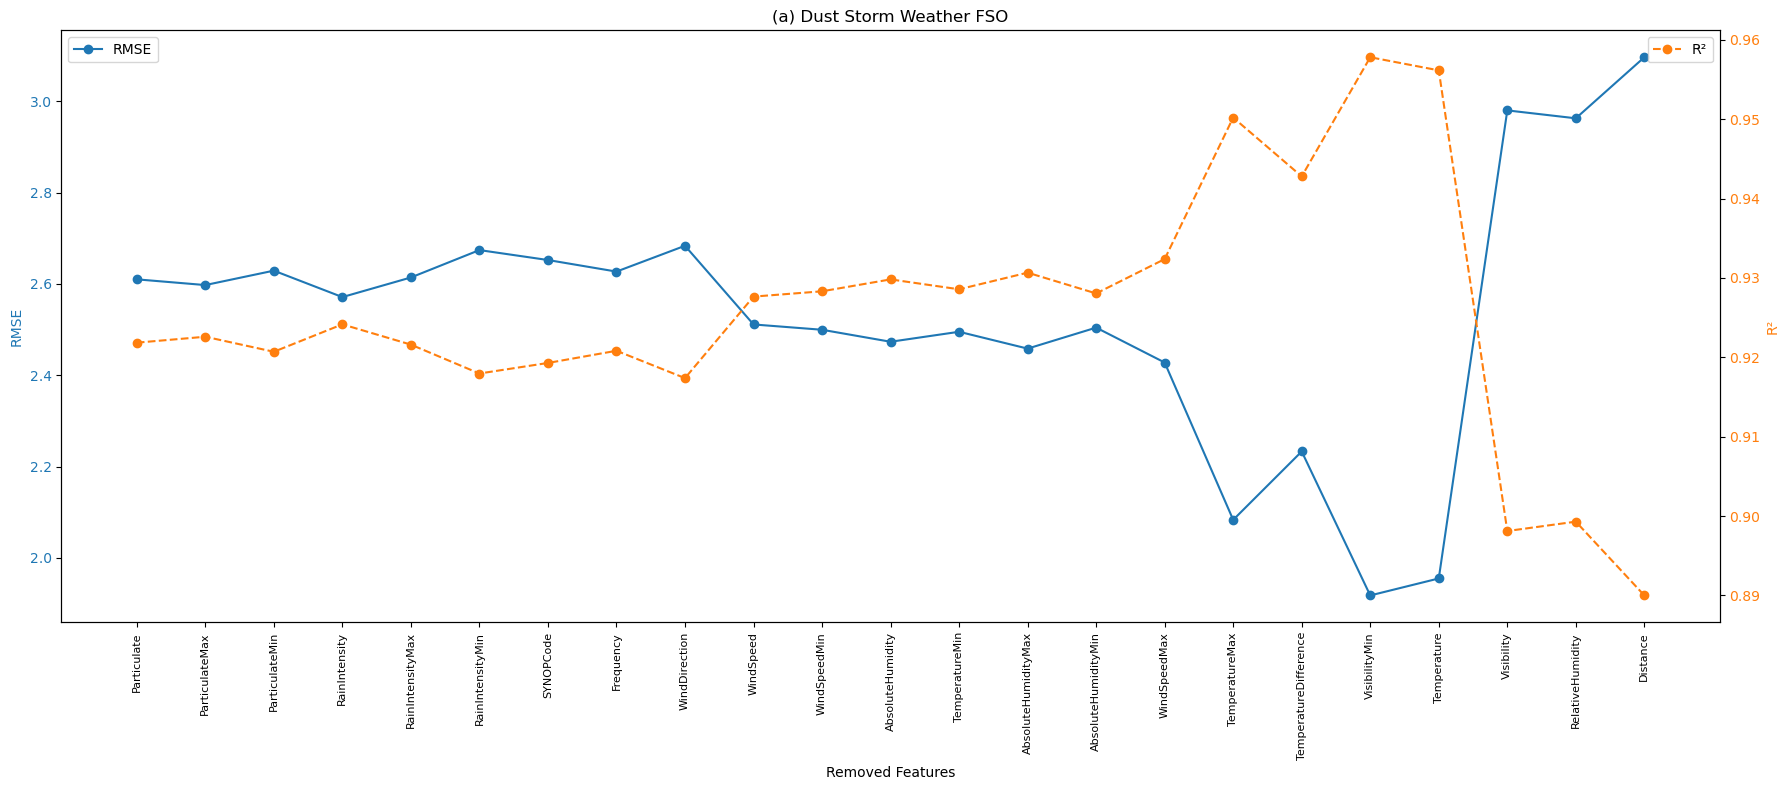

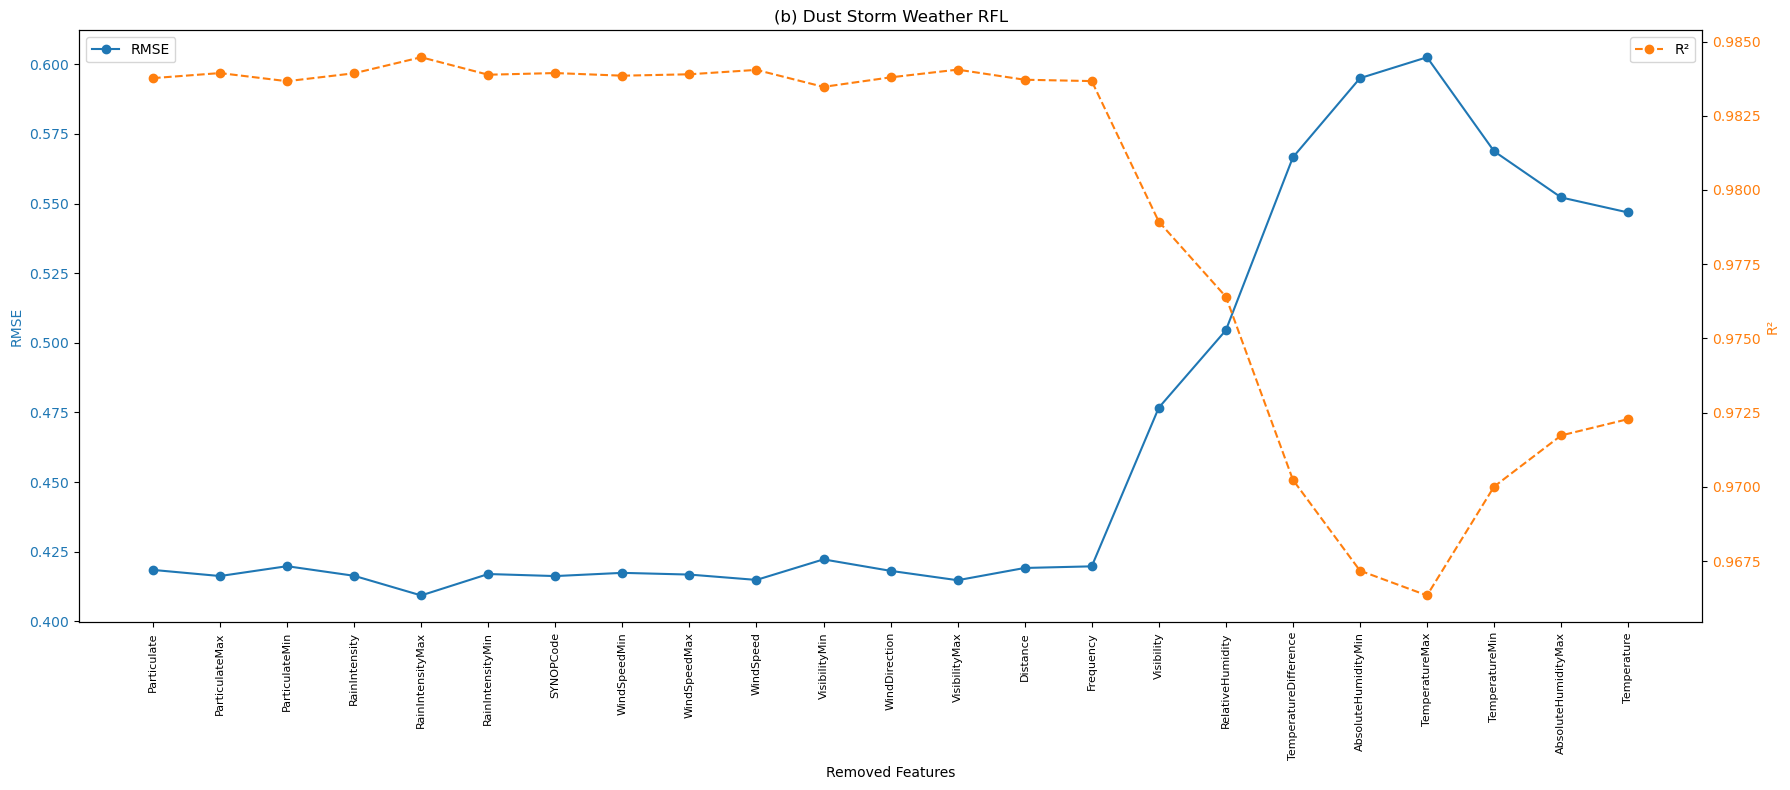

In [10]:
scores_duststorm_fso, rmse_duststorm_fso, r2_duststorm_fso, removed_features_duststorm_fso = backward_selection(X_duststorm, y_duststorm_fso, rf_model)
scores_duststorm_rfl, rmse_duststorm_rfl, r2_duststorm_rfl, removed_features_duststorm_rfl = backward_selection(X_duststorm, y_duststorm_rfl, rf_model)

plot_feature_removal(rmse_duststorm_fso, r2_duststorm_fso, removed_features_duststorm_fso, "(a) Dust Storm Weather FSO")
plot_feature_removal(rmse_duststorm_rfl, r2_duststorm_rfl, removed_features_duststorm_rfl, "(b) Dust Storm Weather RFL")

In [11]:
#fog weather df
fog_df = synop_df[4]
X_fog = fog_df.drop(columns=['FSO_Att', 'RFL_Att', 'Time']) 
y_fog_fso = fog_df['FSO_Att']
y_fog_rfl = fog_df['RFL_Att']
fog_df

,FSO_Att,RFL_Att,AbsoluteHumidity,AbsoluteHumidityMax,AbsoluteHumidityMin,Distance,Frequency,Particulate,ParticulateMax,ParticulateMin,...,TemperatureMax,TemperatureMin,Time,Visibility,VisibilityMax,VisibilityMin,WindDirection,WindSpeed,WindSpeedMax,WindSpeedMin
0,7.516704,10.205776,17.686925,18.801950,17.127009,2964.675409,83500000000,15.179702,15.755447,13.742694,...,25.841196,24.106189,11,9446.603833,9480.921743,8559.072445,88.873997,0.000000,1.024578,0.000000
1,7.274076,9.176182,17.673658,19.108834,16.738390,2960.742928,83500000000,13.900703,15.049485,13.230616,...,24.619464,23.525396,11,257.811683,262.021047,251.982970,91.606445,0.345162,1.238707,0.338332
2,6.982446,10.233360,17.703341,18.502817,16.730091,2955.687061,83500000000,30.443877,31.541453,28.798566,...,26.063762,22.581363,12,34.834294,36.078705,34.615641,107.702237,0.083843,1.432264,0.079327
3,6.988898,7.814947,17.581570,19.158579,16.269258,2957.927370,83500000000,0.000000,0.000000,0.000000,...,25.915664,23.502471,12,29.923493,29.961843,29.529582,70.568955,0.785137,2.112298,0.781756
4,7.345591,9.807727,17.099042,17.730567,15.820980,2959.455092,73500000000,10.021564,10.500068,9.178899,...,24.810671,21.671987,13,3854.820667,4019.194085,3795.403278,54.000214,0.000000,0.221063,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,11.425858,13.919395,4.745776,4.856423,4.443515,4825.634696,73500000000,7.855904,8.221264,7.675225,...,0.711927,0.599517,23,39123.247140,40288.443589,38089.521308,94.485489,0.392430,2.719377,0.378687
462,11.404671,13.287766,4.654969,4.745123,4.204716,4823.781642,83500000000,7.924229,8.207374,7.342110,...,0.778248,0.721995,23,41297.470520,42980.555520,40876.418369,121.240888,1.163113,4.060007,1.120483
463,9.504109,12.415965,4.759933,4.796343,4.430455,4824.610165,83500000000,0.000000,0.000000,0.000000,...,0.619287,0.580434,1,22713.239520,23868.695304,20656.837849,91.478465,0.993168,5.749203,0.982830
464,9.466038,11.152394,3.682117,3.843633,3.603199,4822.483619,83500000000,12.199592,13.374298,11.323808,...,1.322504,1.234432,2,53711.385510,58238.666302,52655.172285,97.813379,1.298064,3.642118,1.258924


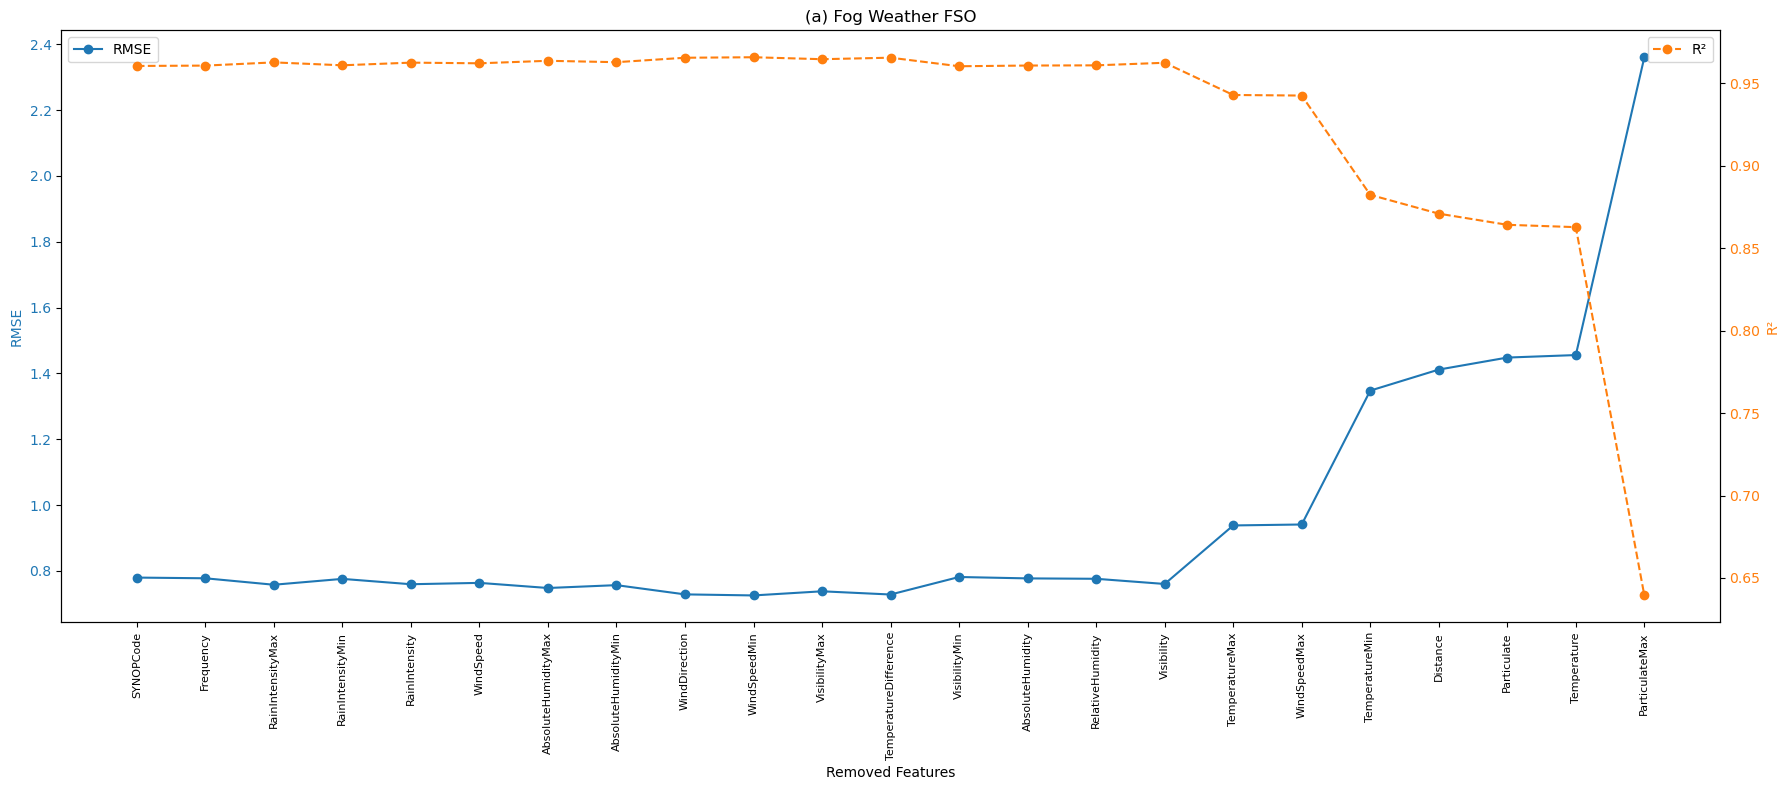

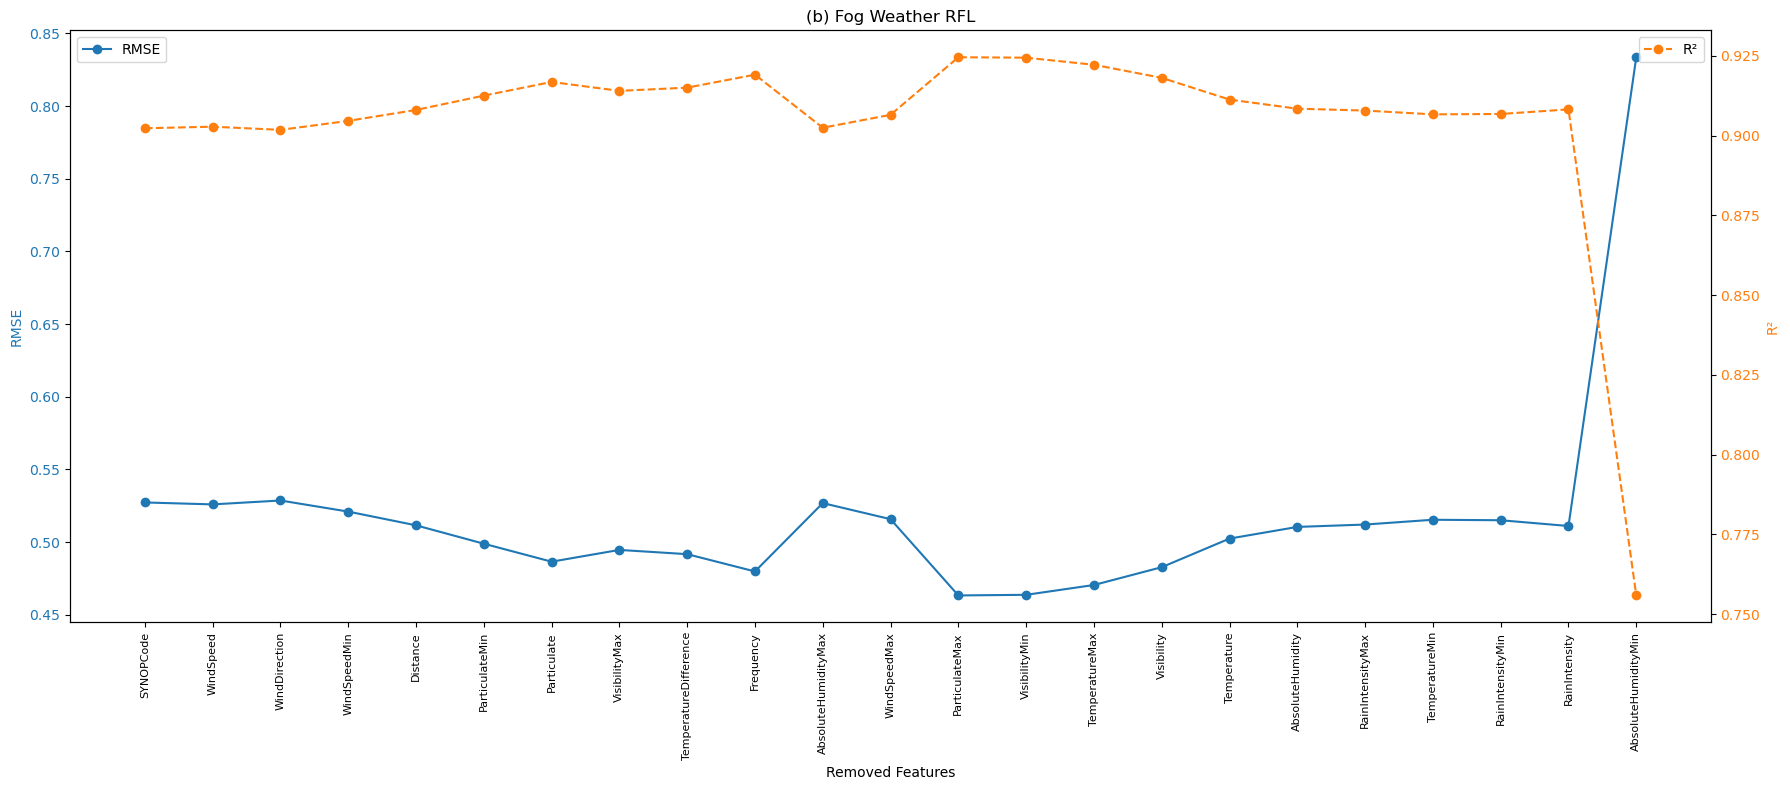

In [12]:
scores_fog_fso, rmse_fog_fso, r2_fog_fso, removed_features_fog_fso = backward_selection(X_fog, y_fog_fso, rf_model)
scores_fog_rfl, rmse_fog_rfl, r2_fog_rfl, removed_features_fog_rfl = backward_selection(X_fog, y_fog_rfl, rf_model)

plot_feature_removal(rmse_fog_fso, r2_fog_fso, removed_features_fog_fso, "(a) Fog Weather FSO")
plot_feature_removal(rmse_fog_rfl, r2_fog_rfl, removed_features_fog_rfl, "(b) Fog Weather RFL")

In [13]:
#drizzle weather df
drizzle_df = synop_df[5]
X_drizzle = drizzle_df.drop(columns=['FSO_Att', 'RFL_Att', 'Time']) 
y_drizzle_fso = drizzle_df['FSO_Att']
y_drizzle_rfl = drizzle_df['RFL_Att']
drizzle_df

,FSO_Att,RFL_Att,AbsoluteHumidity,AbsoluteHumidityMax,AbsoluteHumidityMin,Distance,Frequency,Particulate,ParticulateMax,ParticulateMin,...,TemperatureMax,TemperatureMin,Time,Visibility,VisibilityMax,VisibilityMin,WindDirection,WindSpeed,WindSpeedMax,WindSpeedMin
0,9.300406,5.244079,17.185505,18.653305,16.207035,2121.244675,73500000000,10.808326,11.175887,9.834743,...,27.448687,23.839945,12,28722.336700,29397.995549,25860.792171,88.351940,1.722910,3.031238,1.718081
1,8.871024,7.291416,17.229357,18.677536,16.612769,2118.661428,83500000000,11.054484,11.774542,11.006569,...,26.503255,22.942969,12,34496.427220,36312.940569,32457.442933,49.231282,1.535558,2.443233,1.523731
2,8.069683,7.455618,17.250586,17.783436,15.814667,2115.856825,83500000000,17.766362,17.768354,16.415408,...,26.080919,24.722163,12,35093.541480,37001.968256,34200.532025,88.523877,0.584222,1.319418,0.583062
3,8.162879,5.508202,17.340500,18.893058,16.326125,2114.046745,73500000000,17.861359,18.846504,16.319471,...,26.068064,22.705546,12,31631.188820,34775.885722,31235.733568,89.832847,0.765632,2.518114,0.748049
4,9.808266,6.543880,17.198373,17.348683,15.739655,2115.111762,73500000000,94.388573,98.523937,92.358241,...,24.647955,23.917554,20,11324.489060,11976.843521,10553.346314,118.173932,0.704093,1.946388,0.652809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6600,19.183693,12.115341,4.625150,4.681871,4.580284,4819.920433,73500000000,41.466489,42.211939,37.759875,...,0.105342,0.091717,5,13946.422740,14415.654441,13878.797560,88.070956,0.000000,3.110273,0.000000
6601,19.732313,11.936948,4.570721,4.937725,4.306865,4824.950840,83500000000,49.566655,52.571287,45.846270,...,0.036782,0.035413,5,12213.811180,12940.153828,11242.361964,83.989621,0.000000,2.685586,0.000000
6602,20.658081,12.196225,4.617010,4.890746,4.229281,4826.736964,73500000000,61.084488,61.575022,59.254588,...,0.179898,0.163476,5,9745.869282,9792.910665,9744.534980,82.889269,0.000000,1.401336,0.000000
6603,20.581515,11.982378,4.523463,4.656520,4.361216,4818.382066,83500000000,62.076146,65.953108,60.721674,...,0.053340,0.046824,5,10113.178540,10775.906192,9656.456375,61.367345,0.000000,1.639619,0.000000


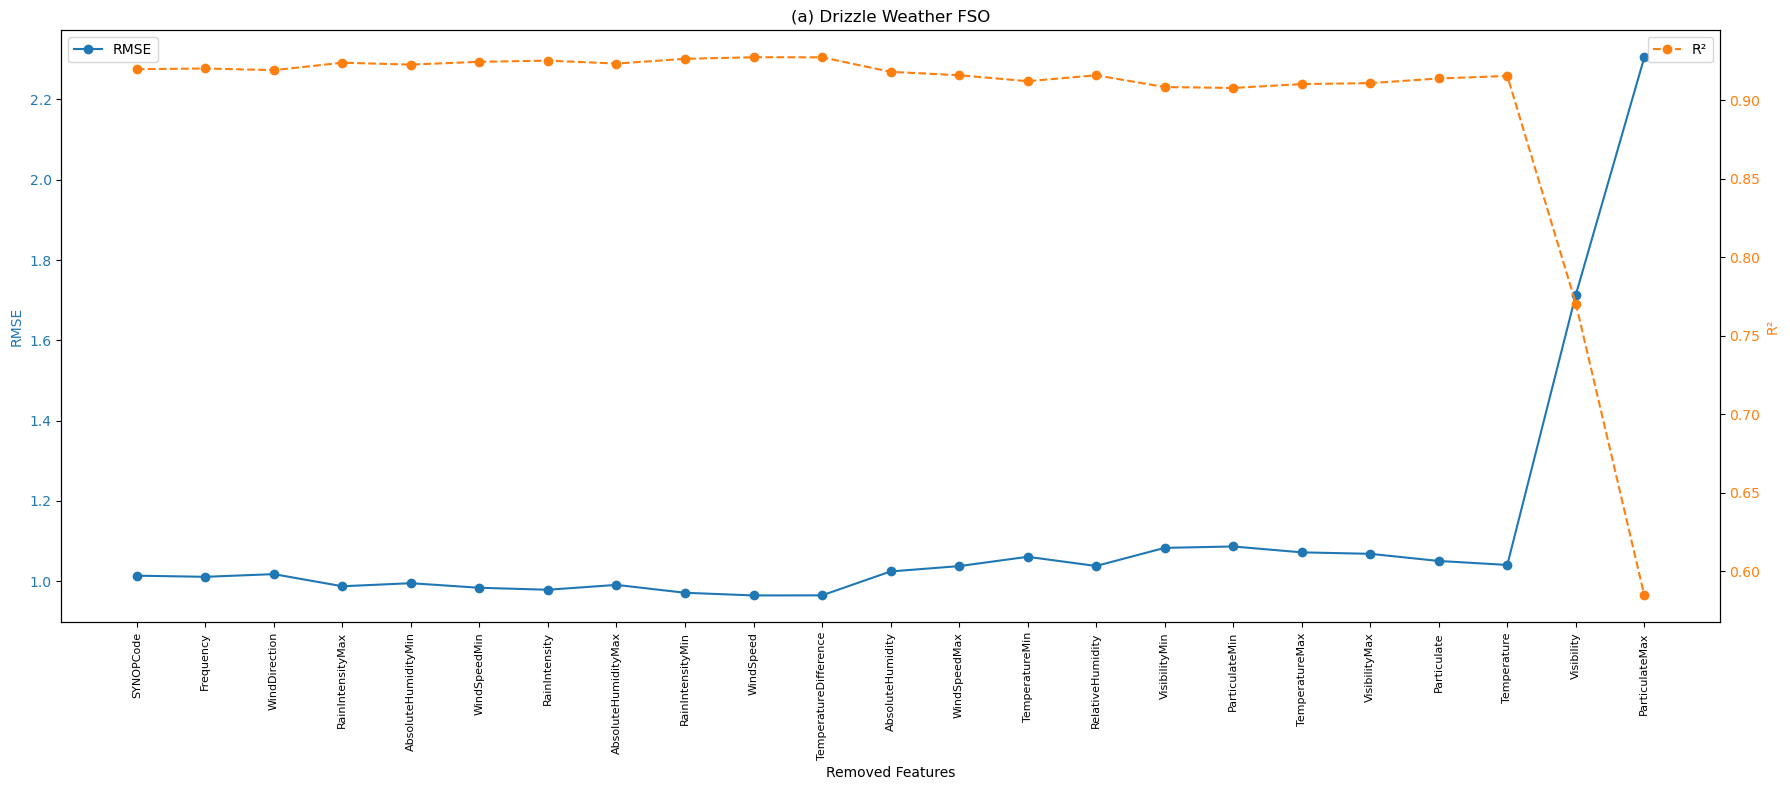

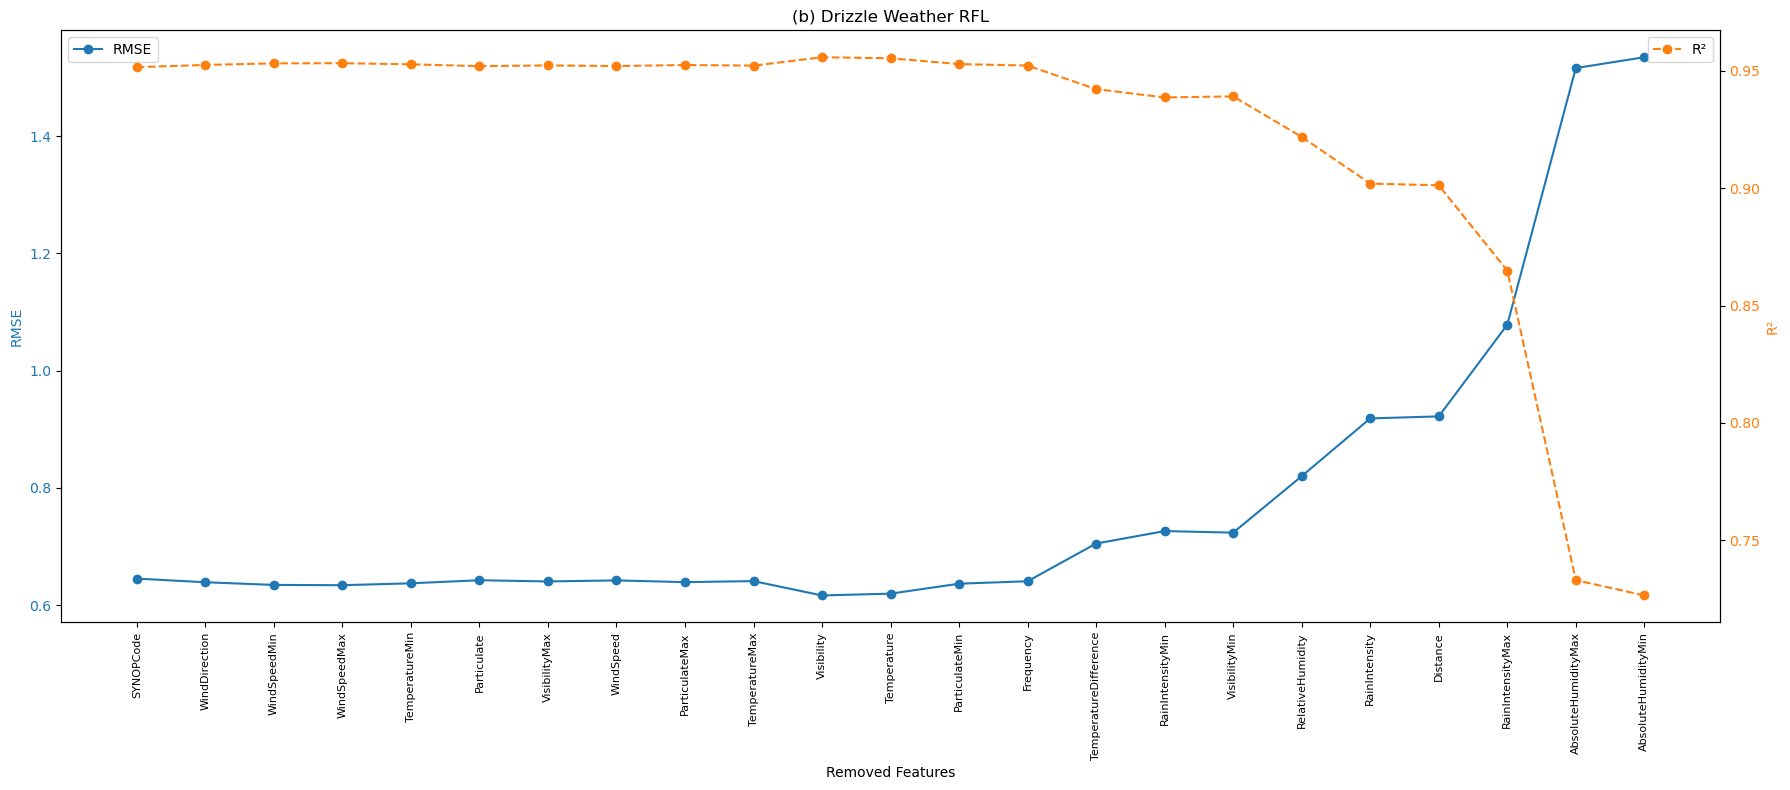

In [14]:
scores_drizzle_fso, rmse_drizzle_fso, r2_drizzle_fso, removed_features_drizzle_fso = backward_selection(X_drizzle, y_drizzle_fso, rf_model)
scores_drizzle_rfl, rmse_drizzle_rfl, r2_drizzle_rfl, removed_features_drizzle_rfl = backward_selection(X_drizzle, y_drizzle_rfl, rf_model)

plot_feature_removal(rmse_drizzle_fso, r2_drizzle_fso, removed_features_drizzle_fso, "(a) Drizzle Weather FSO")
plot_feature_removal(rmse_drizzle_rfl, r2_drizzle_rfl, removed_features_drizzle_rfl, "(b) Drizzle Weather RFL")

In [15]:
#rain weather df
rain_df = synop_df[6]
X_rain = rain_df.drop(columns=['FSO_Att', 'RFL_Att', 'Time']) 
y_rain_fso = rain_df['FSO_Att']
y_rain_rfl = rain_df['RFL_Att']
rain_df

,FSO_Att,RFL_Att,AbsoluteHumidity,AbsoluteHumidityMax,AbsoluteHumidityMin,Distance,Frequency,Particulate,ParticulateMax,ParticulateMin,...,TemperatureMax,TemperatureMin,Time,Visibility,VisibilityMax,VisibilityMin,WindDirection,WindSpeed,WindSpeedMax,WindSpeedMin
0,9.454984,6.192648,17.110882,18.253512,16.136476,2121.742706,73500000000,31.166958,32.256659,28.610426,...,27.199649,24.019869,12,22307.090730,24148.041177,20911.945622,85.849354,1.130489,2.281437,1.073491
1,10.225244,8.419039,17.094251,18.265652,15.789381,2113.301859,83500000000,38.636019,40.251065,36.001099,...,25.992804,23.936297,12,16474.118480,16954.163370,15683.965312,47.570930,1.442658,2.391959,1.347874
2,10.464235,6.846505,17.177814,17.774541,16.768849,2119.552177,73500000000,38.348434,40.345707,36.866758,...,25.827127,22.641892,12,17190.523660,17219.832084,16952.179620,88.563250,1.376956,2.283721,1.250756
3,9.688760,8.868540,17.353415,18.461959,15.814342,2114.326609,73500000000,190.577149,193.722437,173.950657,...,24.451862,22.980583,20,7917.023277,8474.387974,7204.754668,89.522022,1.204814,3.846755,1.161786
4,9.860963,9.403091,17.242779,17.822939,16.460828,2113.137305,83500000000,196.020128,204.063509,196.002472,...,25.482475,22.580847,20,7801.012785,8345.523848,7352.656897,84.904703,0.688722,2.028351,0.676013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25013,9.388685,12.361672,4.453328,4.490946,4.315968,4819.467079,83500000000,7.072978,7.184239,6.769559,...,0.068011,0.062961,5,32693.675790,33675.329175,31475.465928,26.968102,0.000000,2.283157,0.000000
25014,10.592875,12.596448,4.494811,4.816636,4.147151,4824.776440,73500000000,14.023997,14.476732,13.299350,...,-0.061637,-0.070248,5,28576.467700,29251.544490,26632.209114,125.432873,0.000000,0.780760,0.000000
25015,20.593353,12.003689,4.562548,4.840463,4.464255,4827.793957,83500000000,129.129206,132.306381,120.262614,...,0.178013,0.165917,5,5897.208961,6288.001741,5618.975859,83.253349,0.000000,1.091074,0.000000
25016,21.019652,14.149046,4.444572,4.735181,4.118985,4822.518200,73500000000,269.725512,276.902106,259.845617,...,0.178231,0.155395,5,3643.884024,3809.397962,3643.467700,85.765391,0.000000,1.201067,0.000000


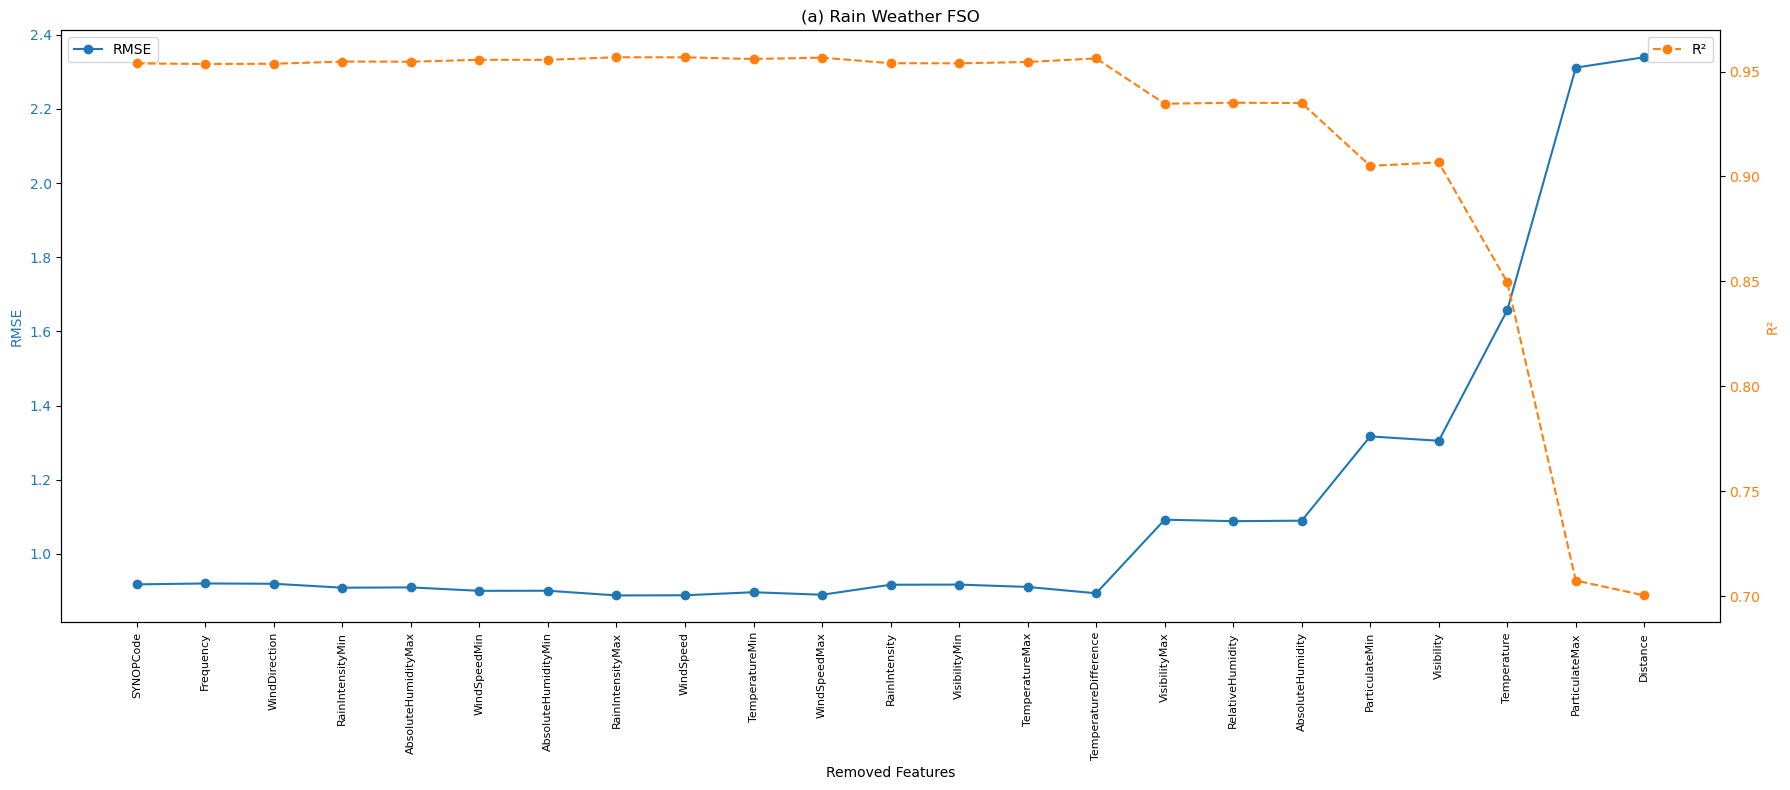

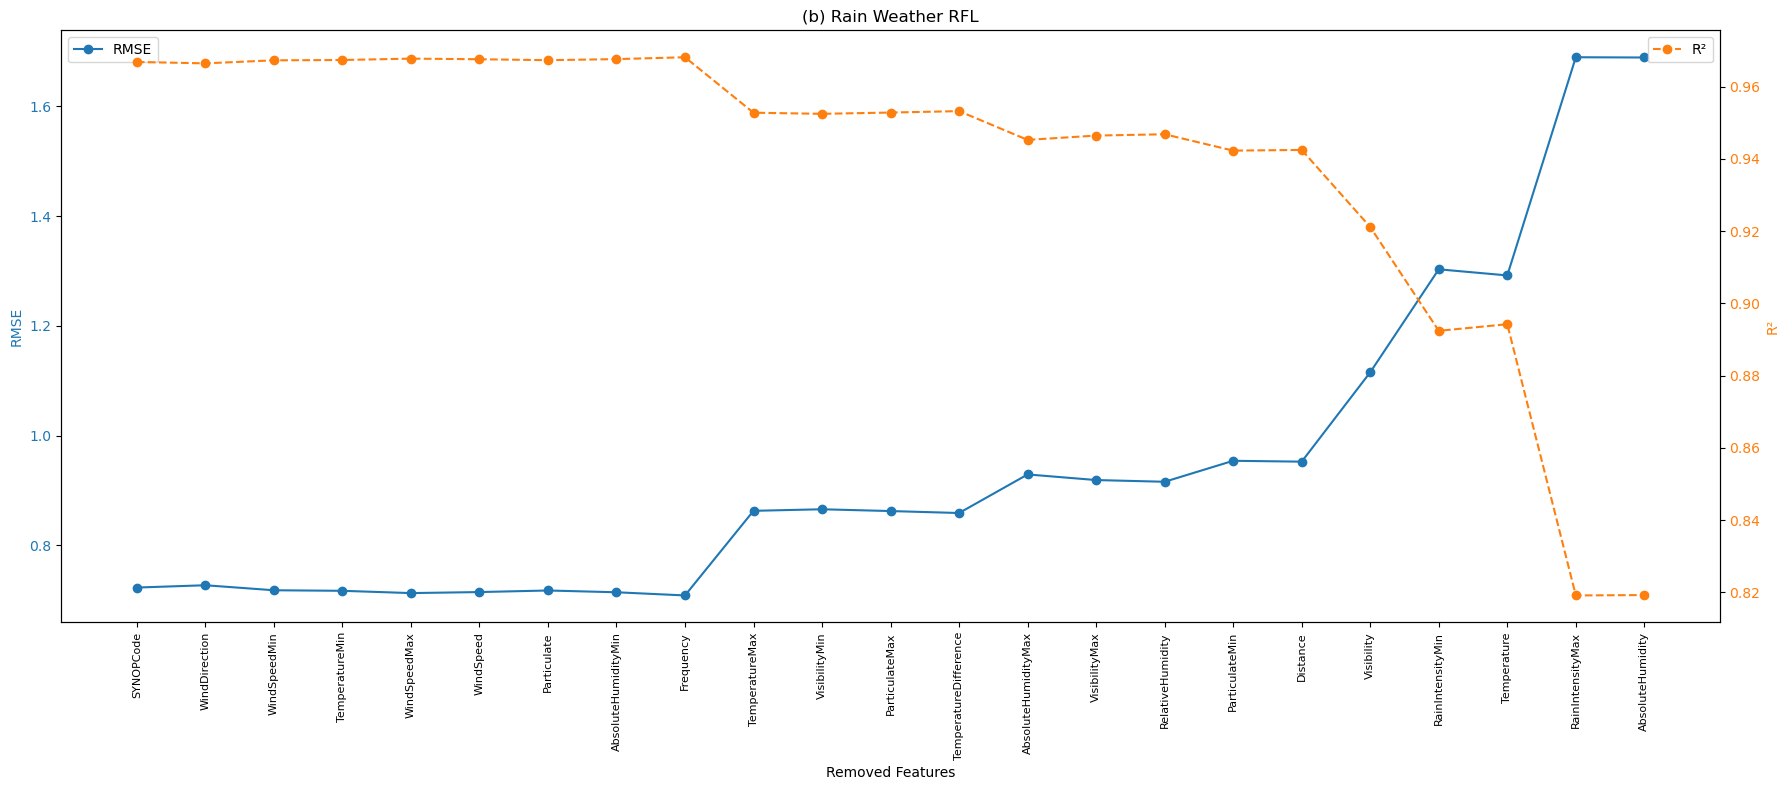

In [16]:
scores_rain_fso, rmse_rain_fso, r2_rain_fso, removed_features_rain_fso = backward_selection(X_rain, y_rain_fso, rf_model)
scores_rain_rfl, rmse_rain_rfl, r2_rain_rfl, removed_features_rain_rfl = backward_selection(X_rain, y_rain_rfl, rf_model)

plot_feature_removal(rmse_rain_fso, r2_rain_fso, removed_features_rain_fso, "(a) Rain Weather FSO")
plot_feature_removal(rmse_rain_rfl, r2_rain_rfl, removed_features_rain_rfl, "(b) Rain Weather RFL")

In [17]:
#snow weather df
snow_df = synop_df[7]
X_snow = snow_df.drop(columns=['FSO_Att', 'RFL_Att', 'Time']) 
y_snow_fso = snow_df['FSO_Att']
y_snow_rfl = snow_df['RFL_Att']
snow_df

,FSO_Att,RFL_Att,AbsoluteHumidity,AbsoluteHumidityMax,AbsoluteHumidityMin,Distance,Frequency,Particulate,ParticulateMax,ParticulateMin,...,TemperatureMax,TemperatureMin,Time,Visibility,VisibilityMax,VisibilityMin,WindDirection,WindSpeed,WindSpeedMax,WindSpeedMin
0,11.842709,11.753958,4.823682,5.008315,4.535829,2016.201547,83500000000,8.946947,9.341061,8.755777,...,0.248796,0.221439,4,261.763900,270.742321,260.772597,107.936320,1.317832,2.393007,1.187603
1,12.929019,11.462908,4.858163,5.220056,4.710651,2019.142871,73500000000,4.929538,5.002985,4.677153,...,0.444140,0.411138,4,698.137375,708.124616,660.255240,81.388080,0.916526,2.180236,0.832091
2,12.824454,11.968017,4.856207,4.970426,4.471158,2018.983152,83500000000,4.930127,5.059871,4.813636,...,0.508478,0.458609,4,298.479758,316.669401,281.499732,77.126993,1.298236,1.810337,1.170564
3,7.037328,12.145403,5.369520,5.854357,5.008599,2017.449639,73500000000,9.057393,9.557519,8.477054,...,1.779828,1.555566,6,819.925058,897.353892,795.091007,82.667069,0.404064,0.632523,0.394734
4,7.204018,12.093161,5.295899,5.821342,5.131989,2021.558937,83500000000,0.000000,0.000000,0.000000,...,1.857622,1.594579,6,1533.128822,1625.542602,1436.800298,105.681073,0.366662,0.705202,0.338302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,15.247160,14.755360,4.789096,5.003914,4.522221,4827.729740,73500000000,86.433649,92.252936,83.274578,...,0.277585,0.244202,0,8475.221404,8757.158032,8140.051825,114.082189,1.954355,5.458253,1.828062
415,14.437509,13.907598,4.680198,4.951615,4.221572,4818.330707,83500000000,41.111193,43.887759,37.843327,...,0.363593,0.343840,0,9206.850133,9778.677598,8534.898416,91.399765,1.985421,4.769706,1.979718
416,14.625421,13.834315,4.647546,4.670323,4.232081,4818.257415,73500000000,41.139111,42.879469,39.453649,...,0.359475,0.322103,0,10989.330680,11035.992517,9917.804884,85.488237,0.862790,5.837625,0.802416
417,10.752150,12.849190,4.853483,5.156220,4.398391,4818.620211,83500000000,7.944964,8.248615,7.566119,...,0.792561,0.687925,5,29930.119490,32257.807803,27442.297148,110.109979,1.797913,3.562836,1.659548


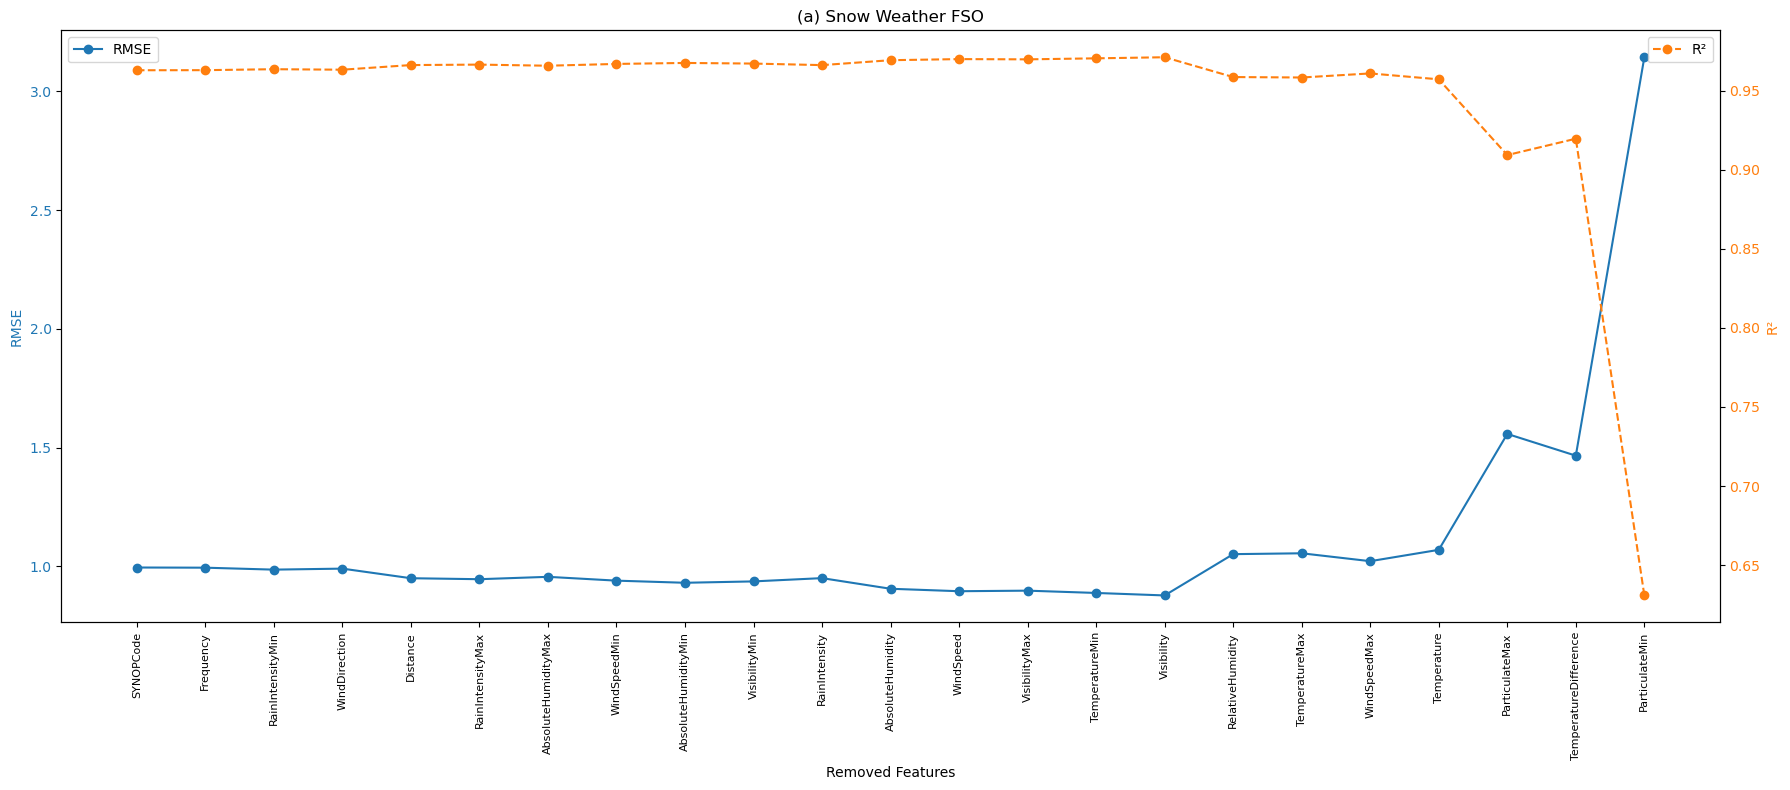

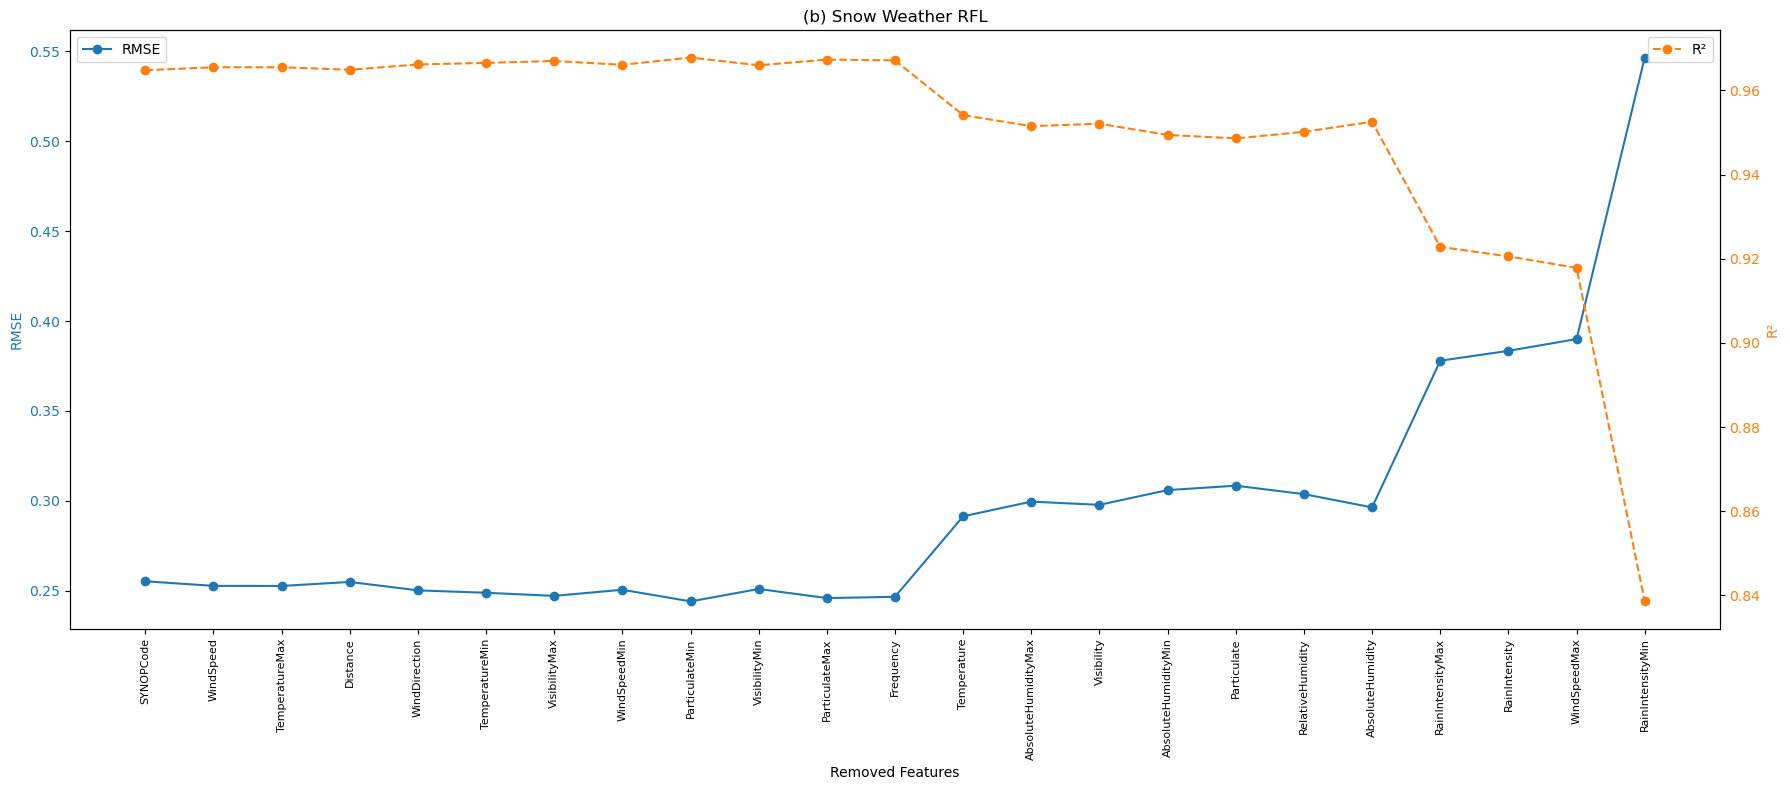

In [18]:
scores_snow_fso, rmse_snow_fso, r2_snow_fso, removed_features_snow_fso = backward_selection(X_snow, y_snow_fso, rf_model)
scores_snow_rfl, rmse_snow_rfl, r2_snow_rfl, removed_features_snow_rfl = backward_selection(X_snow, y_snow_rfl, rf_model)

plot_feature_removal(rmse_snow_fso, r2_snow_fso, removed_features_snow_fso, "(a) Snow Weather FSO")
plot_feature_removal(rmse_snow_rfl, r2_snow_rfl, removed_features_snow_rfl, "(b) Snow Weather RFL")

In [19]:
#showers weather df
showers_df = synop_df[8]
X_showers = showers_df.drop(columns=['FSO_Att', 'RFL_Att', 'Time']) 
y_showers_fso = showers_df['FSO_Att']
y_showers_rfl = showers_df['RFL_Att']
showers_df

,FSO_Att,RFL_Att,AbsoluteHumidity,AbsoluteHumidityMax,AbsoluteHumidityMin,Distance,Frequency,Particulate,ParticulateMax,ParticulateMin,...,TemperatureMax,TemperatureMin,Time,Visibility,VisibilityMax,VisibilityMin,WindDirection,WindSpeed,WindSpeedMax,WindSpeedMin
0,9.649171,7.171949,17.262824,17.650673,15.885822,2121.130895,83500000000,32.370061,34.663677,30.308719,...,26.860662,23.709790,12,26968.35883,27957.497475,25616.013501,62.960858,1.588138,2.496841,1.536522
1,8.171941,7.181019,17.583486,19.298023,16.822755,2113.551707,83500000000,0.000000,0.000000,0.000000,...,25.042082,24.193799,12,39597.93354,40566.225157,38465.319003,99.264971,0.874096,1.614558,0.860217
2,7.535523,5.136881,17.921942,19.598982,16.462489,2118.859344,73500000000,0.000000,0.000000,0.000000,...,22.726741,22.098783,0,37085.29954,37256.455073,34348.245927,89.123599,0.154461,0.184112,0.145983
3,7.707559,7.245108,17.030897,17.421117,15.850073,2115.888623,83500000000,0.000000,0.000000,0.000000,...,26.495755,23.770404,18,36598.46480,36671.764605,34678.512513,103.263943,1.261188,1.623821,1.150654
4,8.356710,4.743570,17.269364,17.970022,17.031733,2117.504373,73500000000,13.912339,14.426880,13.417510,...,24.532186,23.614042,18,25940.86379,28452.583547,24055.994734,100.478040,1.341056,1.797792,1.274658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1711,7.754264,12.366070,4.457111,4.845222,4.293367,4822.933611,83500000000,7.133573,7.398327,6.997204,...,1.697396,1.531851,1,52520.24563,54258.242593,50738.624029,59.911834,1.667727,2.472327,1.649817
1712,7.873959,12.292626,4.496445,4.559748,4.074900,4822.217167,73500000000,0.000000,0.000000,0.000000,...,1.687709,1.461395,1,46382.33318,49745.513223,45330.572511,86.947371,0.883154,2.415317,0.799437
1713,7.809871,12.848060,4.496179,4.871242,4.385426,4824.070455,83500000000,7.931666,8.203054,7.857899,...,1.546206,1.458222,1,53280.21500,56264.323810,49759.611359,105.229774,1.209350,2.920373,1.187349
1714,7.864476,12.714629,4.572546,4.926224,4.242475,4820.074906,73500000000,8.071216,8.423944,7.835229,...,1.600808,1.482892,1,60026.79759,60284.717145,57999.730542,54.783968,1.514047,2.564783,1.390613


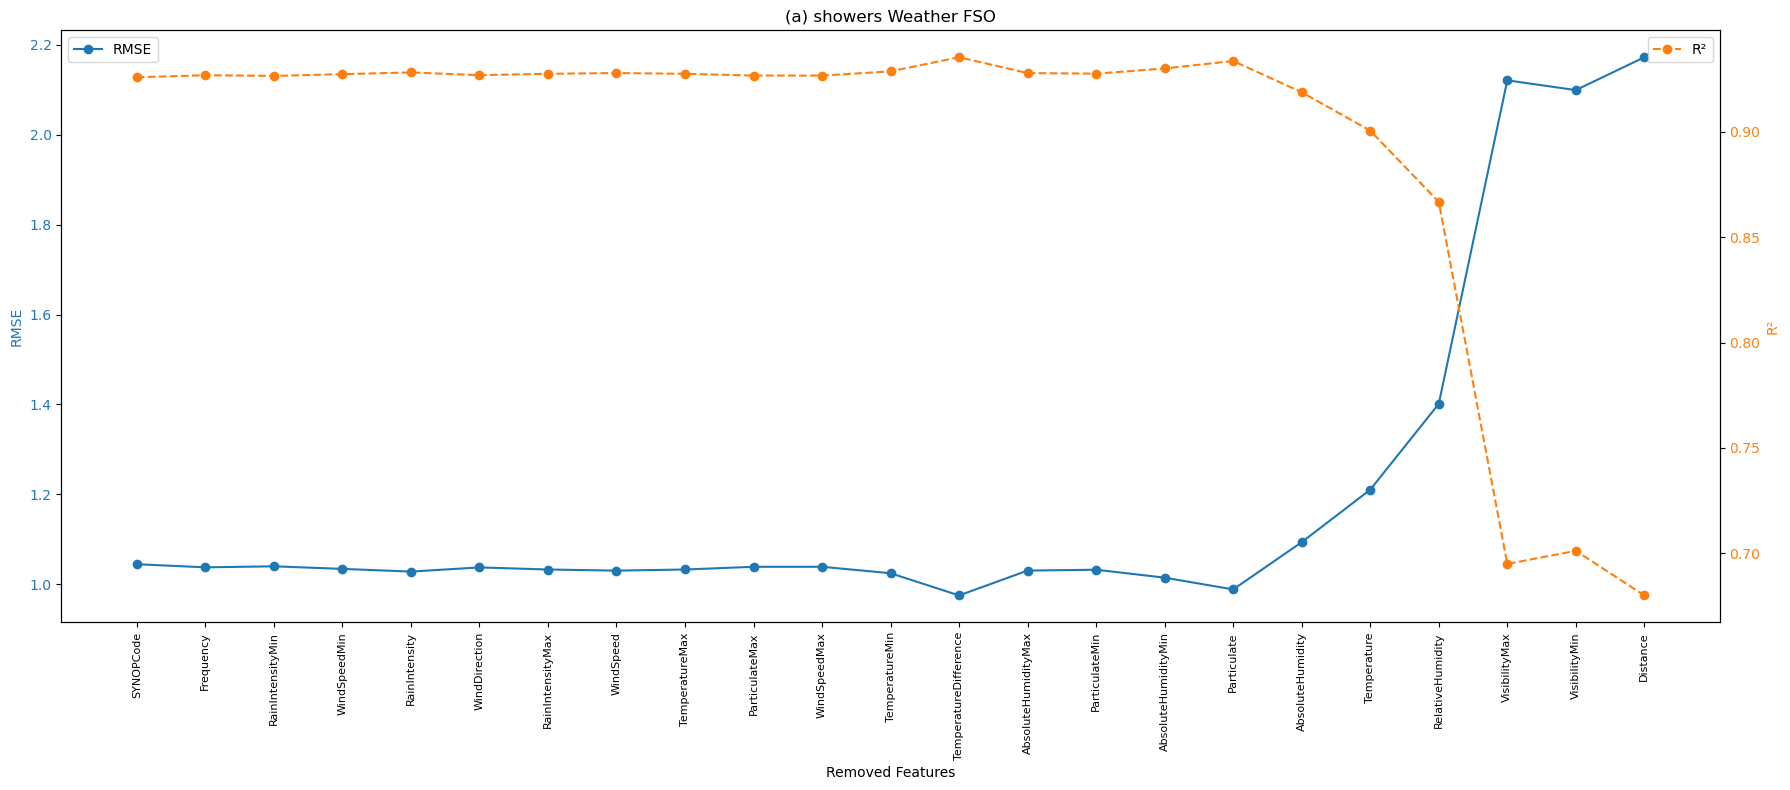

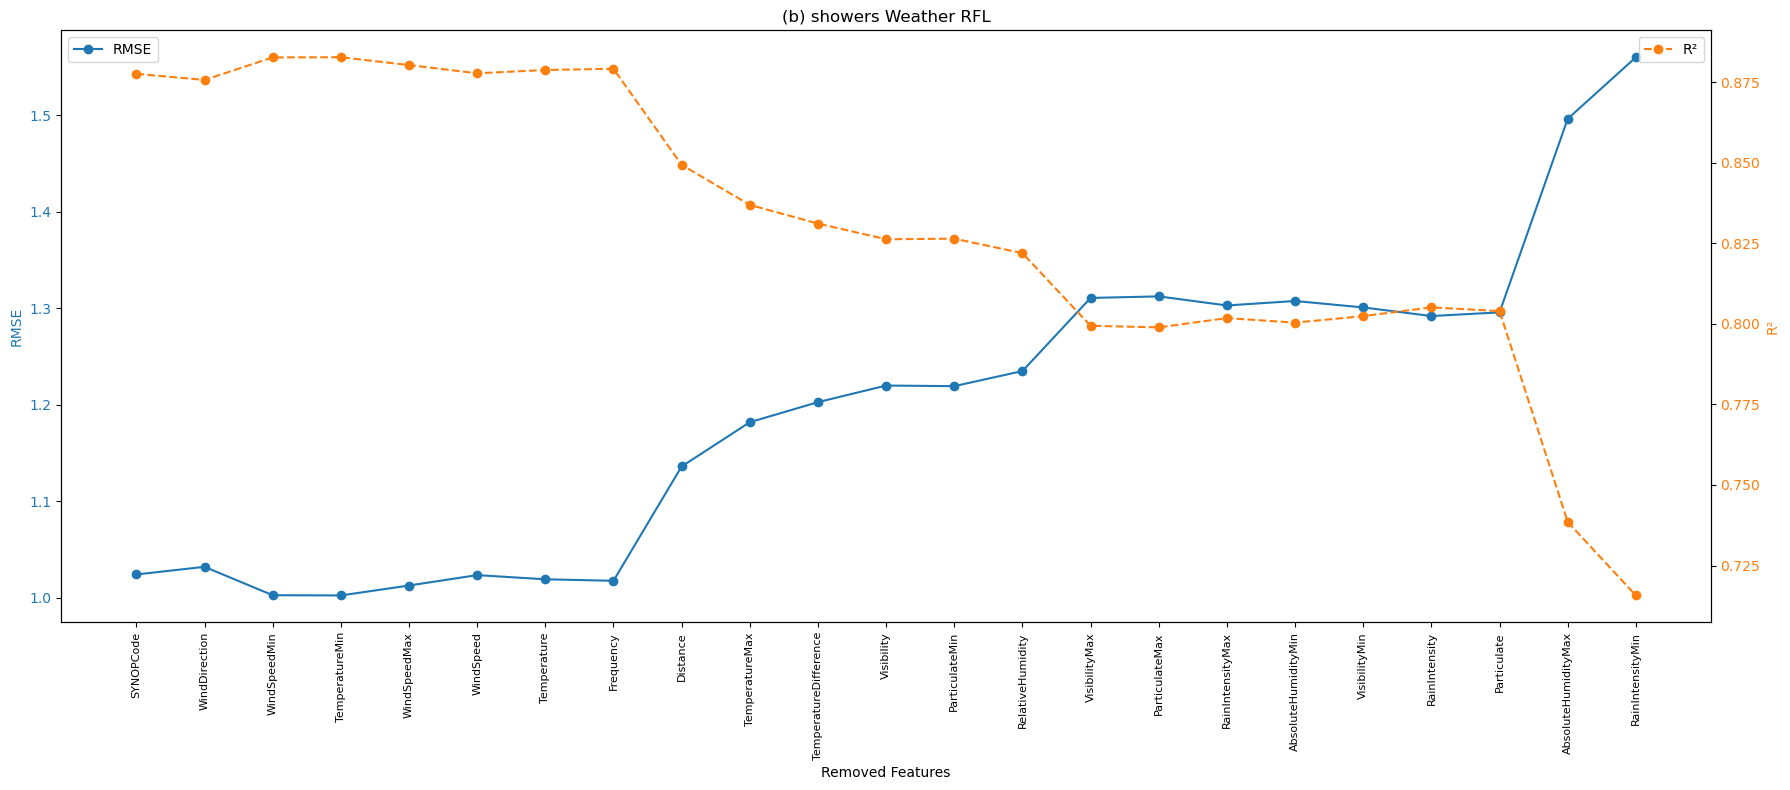

In [20]:
scores_showers_fso, rmse_showers_fso, r2_showers_fso, removed_features_showers_fso = backward_selection(X_showers, y_showers_fso, rf_model)
scores_showers_rfl, rmse_showers_rfl, r2_showers_rfl, removed_features_showers_rfl = backward_selection(X_showers, y_showers_rfl, rf_model)

plot_feature_removal(rmse_showers_fso, r2_showers_fso, removed_features_showers_fso, "(a) showers Weather FSO")
plot_feature_removal(rmse_showers_rfl, r2_showers_rfl, removed_features_showers_rfl, "(b) showers Weather RFL")

In [21]:
#All weather 
final_important_features_fso = ['AbsoluteHumidity', 'VisibilityMin', 'ParticulateMin', 'Temperature', 'Visibility']
final_important_features_rfl = ['RainIntensityMin', 'Temperature', 'RainIntensityMax', 'Distance', 'RainIntensity']

#Clear 
clear_important_features_fso = ['AbsoluteHumidity', 'VisibilityMax', 'TemperatureMax','VisibilityMin','Temperature']
clear_important_features_rfl = ['AbsoluteHumidityMin', 'Visibility', 'Temperature', 'AbsoluteHumidityMax','AbsoluteHumidity']

#dust storm 
duststorm_important_features_fso = ['WindSpeedMax','TemperatureMax','TemperatureDifference','VisibilityMin','Temperature', 'Visibility','RelativeHumidity','Distance']
duststorm_important_features_rfl = ['TemperatureDifference', 'AbsoluteHumidityMin','TemperatureMax','TemperatureMin','AbsoluteHumidityMax','Temperature' ]

#fog 
fog_important_features_fso = ['WindSpeedMax', 'TemperatureMin', 'Distance', 'Particulate', 'Temperature', 'RainIntensityMax']
fog_important_features_rfl = ['RainIntensityMin', 'RainIntensity', 'AbsoluteHumidityMin']

#drizzle
drizzle_important_features_fso = ['Temperature','Visibility', 'ParticulateMax']
drizzle_important_features_rfl = ['Distance', 'RainIntensityMax', 'AbsoluteHumidityMax', 'AbsoluteHumidityMin']

#rain
rain_important_features_fso = ['ParticulateMin', 'Visibility', 'Temperature', 'ParticulateMax', 'Distance']
rain_important_features_rfl = ['Visibility', 'RainIntensityMin', 'Temperature', 'RainIntensityMax', 'AbsoluteHumidity']


#snow
snow_important_features_fso = ['Temperature', 'ParticulateMax', 'TemperatureDifference', 'ParticulateMin']
snow_important_features_rfl = ['AbsoluteHumidity', 'RainIntensityMax', 'RainIntensity', 'WindSpeedMax','RainIntensityMin']

#showers
showers_important_features_fso = ['RelativeHumidity', 'VisibilityMax', 'VisibilityMin', 'Distance']
showers_important_features_rfl = ['RainIntensity', 'Particulate', 'AbsoluteHumidityMax', 'RainIntensityMin']


In [22]:
from sklearn.model_selection import train_test_split

# general model
X_general_fso = X[final_important_features_fso + ['SYNOPCode']]
X_general_rfl = X[final_important_features_rfl + ['SYNOPCode']]
X_train_general_fso, X_test_general_fso, y_train_general_fso, y_test_general_fso = train_test_split(
    X_general_fso, y_fso, test_size=0.3, random_state=42)
X_train_general_rfl, X_test_general_rfl, y_train_general_rfl, y_test_general_rfl = train_test_split(
    X_general_rfl, y_rfl, test_size=0.3, random_state=42)

# Clear weather
X_clear_fso = X_clear[clear_important_features_fso]
X_clear_rfl = X_clear[clear_important_features_rfl]
X_train_clear_fso, X_test_clear_fso, y_train_clear_fso, y_test_clear_fso = train_test_split(
    X_clear_fso, y_clear_fso, test_size=0.3, random_state=42)
X_train_clear_rfl, X_test_clear_rfl, y_train_clear_rfl, y_test_clear_rfl = train_test_split(
    X_clear_rfl, y_clear_rfl, test_size=0.3, random_state=42)

# Dust storm weather
X_duststorm_fso = X_duststorm[duststorm_important_features_fso]
X_duststorm_rfl = X_duststorm[duststorm_important_features_rfl]
X_train_duststorm_fso, X_test_duststorm_fso, y_train_duststorm_fso, y_test_duststorm_fso = train_test_split(
    X_duststorm_fso, y_duststorm_fso, test_size=0.3, random_state=42)
X_train_duststorm_rfl, X_test_duststorm_rfl, y_train_duststorm_rfl, y_test_duststorm_rfl = train_test_split(
    X_duststorm_rfl, y_duststorm_rfl, test_size=0.3, random_state=42)

# Fog weather
X_fog_fso = X_fog[fog_important_features_fso]
X_fog_rfl = X_fog[fog_important_features_rfl]
X_train_fog_fso, X_test_fog_fso, y_train_fog_fso, y_test_fog_fso = train_test_split(
    X_fog_fso, y_fog_fso, test_size=0.3, random_state=42)
X_train_fog_rfl, X_test_fog_rfl, y_train_fog_rfl, y_test_fog_rfl = train_test_split(
    X_fog_rfl, y_fog_rfl, test_size=0.3, random_state=42)

# Drizzle weather
X_drizzle_fso = X_drizzle[drizzle_important_features_fso]
X_drizzle_rfl = X_drizzle[drizzle_important_features_rfl]
X_train_drizzle_fso, X_test_drizzle_fso, y_train_drizzle_fso, y_test_drizzle_fso = train_test_split(
    X_drizzle_fso, y_drizzle_fso, test_size=0.3, random_state=42)
X_train_drizzle_rfl, X_test_drizzle_rfl, y_train_drizzle_rfl, y_test_drizzle_rfl = train_test_split(
    X_drizzle_rfl, y_drizzle_rfl, test_size=0.3, random_state=42)

# Rain weather
X_rain_fso = X_rain[rain_important_features_fso]
X_rain_rfl = X_rain[rain_important_features_rfl]
X_train_rain_fso, X_test_rain_fso, y_train_rain_fso, y_test_rain_fso = train_test_split(
    X_rain_fso, y_rain_fso, test_size=0.3, random_state=42)
X_train_rain_rfl, X_test_rain_rfl, y_train_rain_rfl, y_test_rain_rfl = train_test_split(
    X_rain_rfl, y_rain_rfl, test_size=0.3, random_state=42)

# Snow weather
X_snow_fso = X_snow[snow_important_features_fso]
X_snow_rfl = X_snow[snow_important_features_rfl]
X_train_snow_fso, X_test_snow_fso, y_train_snow_fso, y_test_snow_fso = train_test_split(
    X_snow_fso, y_snow_fso, test_size=0.3, random_state=42)
X_train_snow_rfl, X_test_snow_rfl, y_train_snow_rfl, y_test_snow_rfl = train_test_split(
    X_snow_rfl, y_snow_rfl, test_size=0.3, random_state=42)

# Showers weather
X_showers_fso = X_showers[showers_important_features_fso]
X_showers_rfl = X_showers[showers_important_features_rfl]
X_train_showers_fso, X_test_showers_fso, y_train_showers_fso, y_test_showers_fso = train_test_split(
    X_showers_fso, y_showers_fso, test_size=0.3, random_state=42)
X_train_showers_rfl, X_test_showers_rfl, y_train_showers_rfl, y_test_showers_rfl = train_test_split(
    X_showers_rfl, y_showers_rfl, test_size=0.3, random_state=42)

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt
import numpy as np

# define hyperparameter grid for random forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


def optimize_model(X, y):
    rf = RandomForestRegressor(random_state=42)
    rf_random = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_grid,
        n_iter=5,
        cv=3,
        random_state=42,
        n_jobs=-1
    )
    rf_random.fit(X, y)
    return rf_random.best_params_, rf_random.best_estimator_


print("Optimizing general models...")
best_params_fso_general, _ = optimize_model(X_train_general_fso.drop(columns='SYNOPCode'), y_train_general_fso)
best_params_rfl_general, _ = optimize_model(X_train_general_rfl.drop(columns='SYNOPCode'), y_train_general_rfl)

print("General Model (FSO) best parameter:", best_params_fso_general)
print("General Model (RFL) best parameter:", best_params_rfl_general)

#optimizing the model
print("\nOptimizing specific models for weather conditions...")
weather_conditions_data = {
    'clear': (X_train_clear_fso, y_train_clear_fso, X_train_clear_rfl, y_train_clear_rfl),
    'duststorm': (X_train_duststorm_fso, y_train_duststorm_fso, X_train_duststorm_rfl, y_train_duststorm_rfl),
    'fog': (X_train_fog_fso, y_train_fog_fso, X_train_fog_rfl, y_train_fog_rfl),
    'drizzle': (X_train_drizzle_fso, y_train_drizzle_fso, X_train_drizzle_rfl, y_train_drizzle_rfl),
    'rain': (X_train_rain_fso, y_train_rain_fso, X_train_rain_rfl, y_train_rain_rfl),
    'snow': (X_train_snow_fso, y_train_snow_fso, X_train_snow_rfl, y_train_snow_rfl),
    'showers': (X_train_showers_fso, y_train_showers_fso, X_train_showers_rfl, y_train_showers_rfl)
}

weather_best_params = {}
for condition, (X_fso, y_fso, X_rfl, y_rfl) in weather_conditions_data.items():
    print(f"Optimizing models for weather condition: {condition}")
    best_params_fso, _ = optimize_model(X_fso, y_fso)
    best_params_rfl, _ = optimize_model(X_rfl, y_rfl)
    weather_best_params[condition] = {
        'FSO': best_params_fso,
        'RFL': best_params_rfl
    }
    print(f"{condition} FSO best parameter:", best_params_fso)
    print(f"{condition} RFL best parameter:", best_params_rfl)

print("\nAll specific models trained successfully.")

Optimizing general models...
General Model (FSO) best parameter: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
General Model (RFL) best parameter: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10}

Optimizing specific models for weather conditions...
Optimizing models for weather condition: clear
clear FSO best parameter: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
clear RFL best parameter: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Optimizing models for weather condition: duststorm
duststorm FSO best parameter: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 10}
duststorm RFL best parameter: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Optimizing models for weather condition: fog
fog FSO best parameter: {'n_estimators': 200, 'min_samples_split':

Training General Models...
General models trained successfully.

Training Specific Models...
Training models for Weather Condition: clear
  FSO Specific Model for clear trained successfully.
  RFL Specific Model for clear trained successfully.
Training models for Weather Condition: duststorm
  FSO Specific Model for duststorm trained successfully.
  RFL Specific Model for duststorm trained successfully.
Training models for Weather Condition: fog
  FSO Specific Model for fog trained successfully.
  RFL Specific Model for fog trained successfully.
Training models for Weather Condition: drizzle
  FSO Specific Model for drizzle trained successfully.
  RFL Specific Model for drizzle trained successfully.
Training models for Weather Condition: rain
  FSO Specific Model for rain trained successfully.
  RFL Specific Model for rain trained successfully.
Training models for Weather Condition: snow
  FSO Specific Model for snow trained successfully.
  RFL Specific Model for snow trained successfu

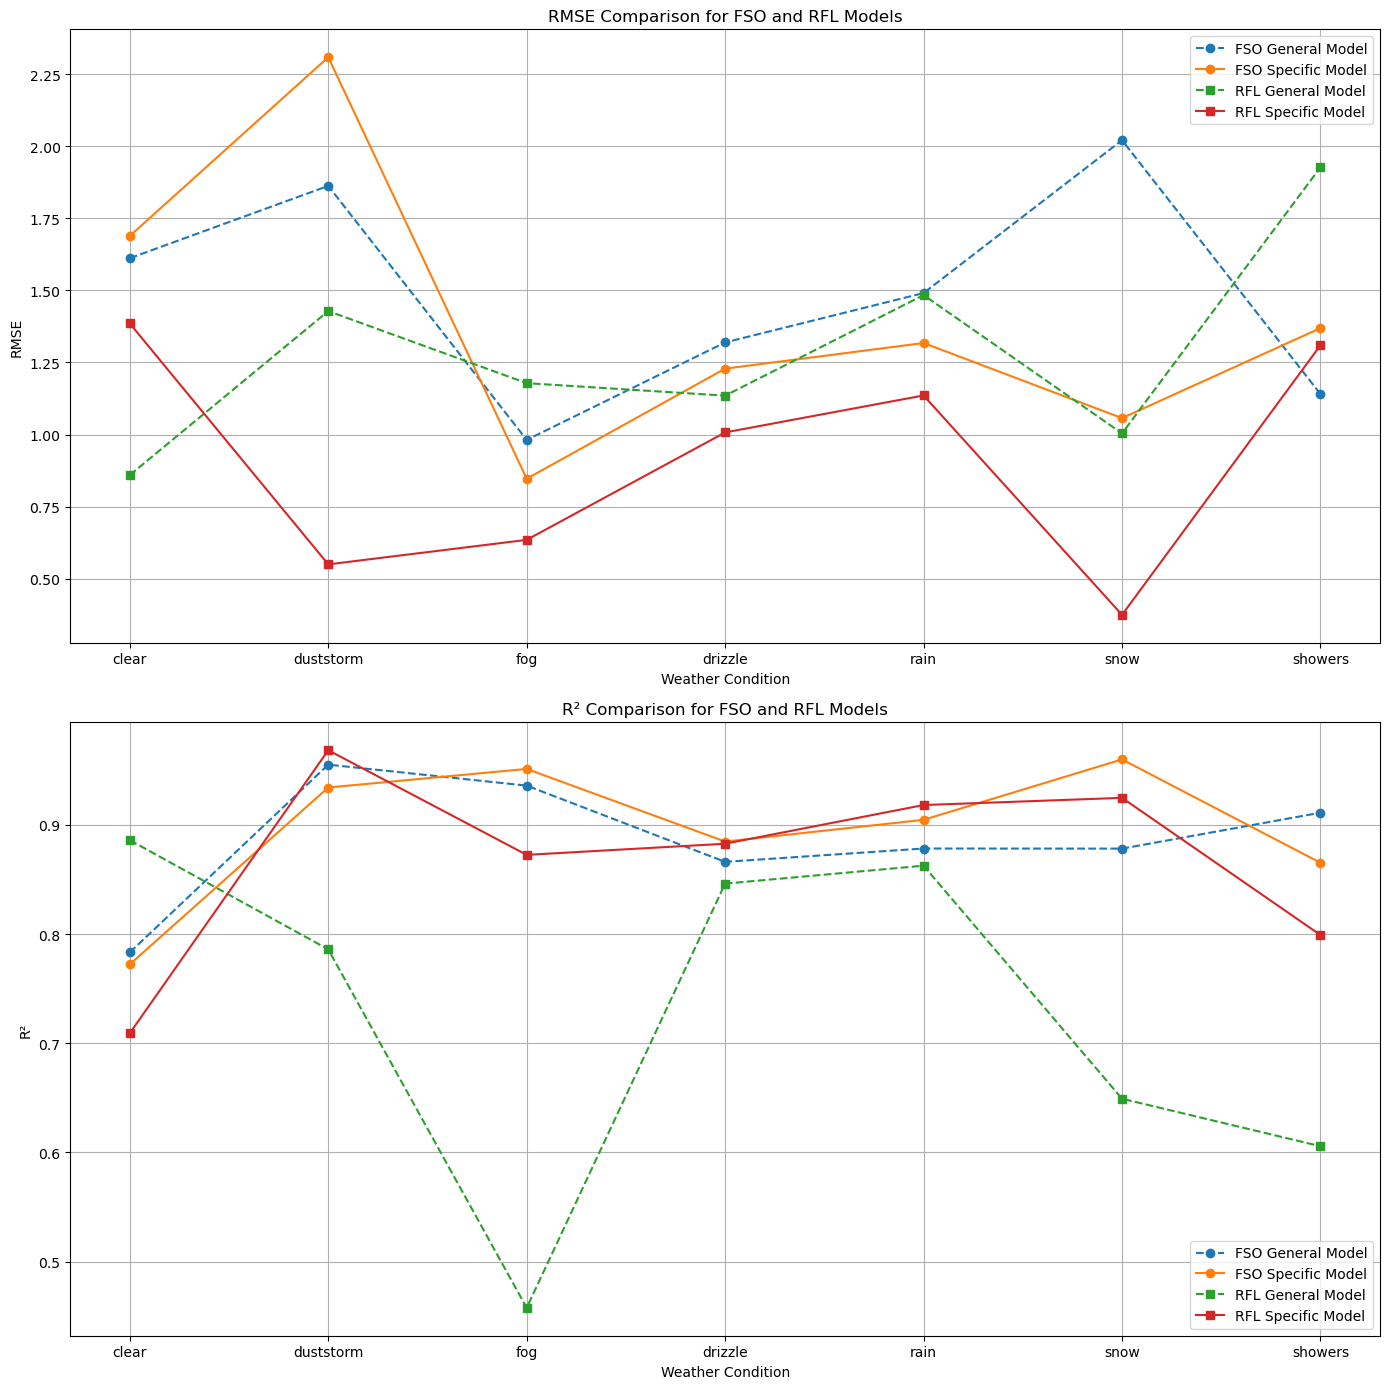

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

# Evaluate the model
def evaluate_model(model, X_test, y_test):
    
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = sqrt(mean_squared_error(y_test, y_pred))    
    return r2, rmse

# define SYNOP code
synop_code_mapping = {
    0: 'clear',
    3: 'duststorm',
    4: 'fog',
    5: 'drizzle',
    6: 'rain',
    7: 'snow',
    8: 'showers'
}

# Weather condtions
weather_conditions = [synop_code_mapping[code] for code in synop_code_mapping.keys()]

# initialising 
rmse_generic_fso, r2_generic_fso = [], []
rmse_specific_fso, r2_specific_fso = [], []
rmse_generic_rfl, r2_generic_rfl = [], []
rmse_specific_rfl, r2_specific_rfl = [], []

# General model
print("Training General Models...")
generic_model_fso = RandomForestRegressor(**best_params_fso_general, random_state=42)
generic_model_rfl = RandomForestRegressor(**best_params_rfl_general, random_state=42)

# Training General Models
generic_model_fso.fit(X_train_general_fso.drop(columns='SYNOPCode'), y_train_general_fso)
generic_model_rfl.fit(X_train_general_rfl.drop(columns='SYNOPCode'), y_train_general_rfl)
print("General models trained successfully.\n")

# Specific Models
print("Training Specific Models...")
specific_models = {}

for weather in weather_conditions:
    print(f"Training models for Weather Condition: {weather}")
    
    # FSO specific model
    specific_model_fso = RandomForestRegressor(**weather_best_params[weather]['FSO'], random_state=42)
    specific_model_fso.fit(eval(f"X_train_{weather}_fso"), eval(f"y_train_{weather}_fso"))
    
    specific_models[weather] = {'FSO': specific_model_fso}
    print(f"  FSO Specific Model for {weather} trained successfully.")

    # RFL specific model
    specific_model_rfl = RandomForestRegressor(**weather_best_params[weather]['RFL'], random_state=42)
    specific_model_rfl.fit(eval(f"X_train_{weather}_rfl"), eval(f"y_train_{weather}_rfl"))
    

    specific_models[weather]['RFL'] = specific_model_rfl
    print(f"  RFL Specific Model for {weather} trained successfully.")

print("\nAll specific models trained successfully.\n")

# Evaluation 
print("Performance by Weather Condition:\n")
for weather in weather_conditions:
    print(f"Weather Condition: {weather}")

    #SYNOPCode
    condition_code = [code for code, name in synop_code_mapping.items() if name == weather][0]

   
    # General model testing for fso 
    X_test_cond_fso = X_test_general_fso[X_test_general_fso['SYNOPCode'] == condition_code].drop(columns='SYNOPCode')
    y_test_cond_fso = y_test_general_fso[X_test_general_fso['SYNOPCode'] == condition_code]

    if X_test_cond_fso.empty:
        print("  FSO: No data available for general model.")
    else:
        # General model evaluation fso
        r2_g_fso, rmse_g_fso = evaluate_model(generic_model_fso, X_test_cond_fso, y_test_cond_fso)
        rmse_generic_fso.append(rmse_g_fso)
        r2_generic_fso.append(r2_g_fso)
        print(f"  FSO General Model: RMSE={rmse_g_fso:.3f}, R²={r2_g_fso:.3f}")

    # Specific model fso
    X_test_specific_fso = eval(f"X_test_{weather}_fso")
    y_test_specific_fso = eval(f"y_test_{weather}_fso")

    # Specific model testing fso
    specific_model_fso = specific_models[weather]['FSO']
    r2_s_fso, rmse_s_fso = evaluate_model(specific_model_fso, X_test_specific_fso, y_test_specific_fso)
    rmse_specific_fso.append(rmse_s_fso)
    r2_specific_fso.append(r2_s_fso)
    print(f"  FSO Specific Model: RMSE={rmse_s_fso:.3f}, R²={r2_s_fso:.3f}")


    # General model rfl
    X_test_cond_rfl = X_test_general_rfl[X_test_general_rfl['SYNOPCode'] == condition_code].drop(columns='SYNOPCode')
    y_test_cond_rfl = y_test_general_rfl[X_test_general_rfl['SYNOPCode'] == condition_code]

    if X_test_cond_rfl.empty:
        print("  RFL: No data available for general model.\n")
    else:
        # General model evaluation rfl
        r2_g_rfl, rmse_g_rfl = evaluate_model(generic_model_rfl, X_test_cond_rfl, y_test_cond_rfl)
        rmse_generic_rfl.append(rmse_g_rfl)
        r2_generic_rfl.append(r2_g_rfl)
        print(f"  RFL General Model: RMSE={rmse_g_rfl:.3f}, R²={r2_g_rfl:.3f}")

    # Specific model fso
    X_test_specific_rfl = eval(f"X_test_{weather}_rfl")
    y_test_specific_rfl = eval(f"y_test_{weather}_rfl")

    # Specific model evaluation fso
    specific_model_rfl = specific_models[weather]['RFL']
    r2_s_rfl, rmse_s_rfl = evaluate_model(specific_model_rfl, X_test_specific_rfl, y_test_specific_rfl)
    rmse_specific_rfl.append(rmse_s_rfl)
    r2_specific_rfl.append(r2_s_rfl)
    print(f"  RFL Specific Model: RMSE={rmse_s_rfl:.3f}, R²={r2_s_rfl:.3f}\n")

def plot_combined_generic_vs_specific(weather_conditions, 
                                      rmse_generic_fso, rmse_specific_fso, 
                                      rmse_generic_rfl, rmse_specific_rfl, 
                                      r2_generic_fso, r2_specific_fso, 
                                      r2_generic_rfl, r2_specific_rfl):

    weather_labels = weather_conditions
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 14))

    # Plot RMSE
    ax1.plot(weather_labels, rmse_generic_fso, label='FSO General Model', marker='o', linestyle='--')
    ax1.plot(weather_labels, rmse_specific_fso, label='FSO Specific Model', marker='o', linestyle='-')
    ax1.plot(weather_labels, rmse_generic_rfl, label='RFL General Model', marker='s', linestyle='--')
    ax1.plot(weather_labels, rmse_specific_rfl, label='RFL Specific Model', marker='s', linestyle='-')
    ax1.set_title('RMSE Comparison for FSO and RFL Models')
    ax1.set_xlabel('Weather Condition')
    ax1.set_ylabel('RMSE')
    ax1.legend(loc='upper right')
    ax1.grid()

    # Plot R^2 
    ax2.plot(weather_labels, r2_generic_fso, label='FSO General Model', marker='o', linestyle='--')
    ax2.plot(weather_labels, r2_specific_fso, label='FSO Specific Model', marker='o', linestyle='-')
    ax2.plot(weather_labels, r2_generic_rfl, label='RFL General Model', marker='s', linestyle='--')
    ax2.plot(weather_labels, r2_specific_rfl, label='RFL Specific Model', marker='s', linestyle='-')
    ax2.set_title('R² Comparison for FSO and RFL Models')
    ax2.set_xlabel('Weather Condition')
    ax2.set_ylabel('R²')
    ax2.legend(loc='lower right')
    ax2.grid()


    plt.tight_layout()
    plt.show()

#  comparison between models 
plot_combined_generic_vs_specific(
    weather_conditions, rmse_generic_fso, rmse_specific_fso,
    rmse_generic_rfl, rmse_specific_rfl,
    r2_generic_fso, r2_specific_fso,
    r2_generic_rfl, r2_specific_rfl
)